In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##FuXi-S2S
The FuXi-S2S model is an innovative probabilistic weather forecasting architecture that combines transformers with variational methods. Its key idea is to model forecast uncertainty through explicit distribution learning rather than single deterministic predictions.

The architecture model was created from scratch based on research paper 'Chen, L., Zhong, X., Li, H., Wu, J., Lu, B., Chen, D., Xie, S., Chao, Q., Lin, C., Hu, Z., & Qi, Y. (2023, December 15). FuXi-S2S: A machine learning model that outperforms conventional global subseasonal forecast models. arXiv.org. https://arxiv.org/abs/2312.09926'. However, the model's architecture and hyperparameters were altered to increase memory efficiency due to resource constraints during training.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import xarray as xr
from torch.utils.data import Dataset, DataLoader
import math
import os
import time
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

def load_compiled_state_dict(model, state_dict_path):
    """
    Loads a state dict that was saved from a compiled model

    Args:
        model: The model to load weights into
        state_dict_path: Path to the saved state dict

    Returns:
        The model with loaded weights
    """
    state_dict = torch.load(state_dict_path)

    has_orig_mod = any(k.startswith('_orig_mod.') for k in state_dict.keys())

    if has_orig_mod:
        print("Detected compiled model state dict, removing '_orig_mod.' prefix...")
        # Create a new state dict with modified keys
        new_state_dict = {}
        for key, value in state_dict.items():
            if key.startswith('_orig_mod.'):
                new_key = key[len('_orig_mod.'):]
                new_state_dict[new_key] = value
            else:
                new_state_dict[key] = value

        state_dict = new_state_dict

    model.load_state_dict(state_dict)
    print(f"Successfully loaded model from {state_dict_path}")
    return model

def save_model(model, path):
    """
    Save a model that might be compiled

    Args:
        model: The model to save (might be compiled)
        path: Path to save the model
    """
    # If the model is compiled, we need to access the original module
    if hasattr(model, '_orig_mod'):
        print("Detected compiled model, saving original module...")
        torch.save(model._orig_mod.state_dict(), path)
    elif isinstance(model, nn.DataParallel):
        # For DataParallel models, access the module
        if hasattr(model.module, '_orig_mod'):
            print("Detected compiled DataParallel model, saving original module...")
            torch.save(model.module._orig_mod.state_dict(), path)
        else:
            torch.save(model.module.state_dict(), path)
    else:
        # Regular model saving
        torch.save(model.state_dict(), path)

    print(f"Model saved to {path}")

class PositionalEncoding(nn.Module):
    """
    Positional encoding for the transformer architecture
    """
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TransformerBlock(nn.Module):
    """
    Transformer block used in both encoder and decoder - memory efficient version
    """
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerBlock, self).__init__()
        try:
            self.self_attn = nn.MultiheadAttention(
                d_model, nhead, dropout=dropout, batch_first=True,
                use_memory_efficient_attention=True
            )
            print("Using memory-efficient attention")
        except TypeError:
            self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = nn.GELU()

    def forward(self, x):
        # Store original shape
        orig_shape = x.shape

        # Handle 4D tensors (spatial data)
        if len(orig_shape) > 3:
            batch, ch, h, w = orig_shape

            # Reshape to [batch, seq_len, features] for transformer operations
            x_2d = x.reshape(batch, ch, h*w).permute(0, 2, 1)  # [batch, h*w, channels]

            # Apply layer norm (now channels are the last dimension)
            norm_x = self.norm1(x_2d)

            # Apply self-attention
            attn_out, _ = self.self_attn(norm_x, norm_x, norm_x)

            # Apply dropout
            attn_out = self.dropout(attn_out)

            # Skip connection
            x_2d = x_2d + attn_out

            # Apply layer norm
            norm_x = self.norm2(x_2d)

            # Apply FFN
            ffn_out = self.linear1(norm_x)
            ffn_out = self.activation(ffn_out)
            ffn_out = self.dropout1(ffn_out)
            ffn_out = self.linear2(ffn_out)
            ffn_out = self.dropout2(ffn_out)

            # Skip connection
            x_2d = x_2d + ffn_out

            # Reshape back to 4D
            x = x_2d.permute(0, 2, 1).reshape(batch, ch, h, w)

        else:
            # Standard transformer block for 3D tensors [batch, seq_len, features]
            norm_x = self.norm1(x)
            attn_out, _ = self.self_attn(norm_x, norm_x, norm_x)
            x = x + self.dropout(attn_out)

            norm_x = self.norm2(x)
            ffn_out = self.linear2(self.dropout1(self.activation(self.linear1(norm_x))))
            x = x + self.dropout2(ffn_out)

        return x

class FuXiS2SEncoder(nn.Module):
    """
    Encoder for the FuXi-S2S model - memory efficient version
    """
    def __init__(self, input_channels, hidden_dim=256, z_dim=32, latent_h=14, latent_w=14, num_blocks=2):
        super(FuXiS2SEncoder, self).__init__()

        self.hidden_dim = hidden_dim
        self.z_dim = z_dim
        self.latent_h = latent_h
        self.latent_w = latent_w

        # 2D convolution that reduces time dimension by half
        self.conv = nn.Conv2d(input_channels * 2, hidden_dim, kernel_size=(1, 1), stride=1, padding=0)

        # Transformer blocks - reduced to fewer blocks for faster training
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model=hidden_dim, nhead=8, dim_feedforward=hidden_dim*2, dropout=0.1)
            for _ in range(num_blocks)
        ])

        # Projections for Gaussian distribution parameters
        self.mu_proj = nn.Conv2d(hidden_dim, z_dim, kernel_size=1)
        self.logvar_proj = nn.Conv2d(hidden_dim, z_dim, kernel_size=1)
        self.cov_proj = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1)

        # Lead time embedding
        self.lead_time_embedding = nn.Embedding(45, hidden_dim)  # For 44-day forecast horizon

    def forward(self, x, lead_time):
        """
        Args:
            x: Input tensor of shape [batch_size, 2, channels, lat, lon]
            lead_time: Lead time tensor of shape [batch_size]
        """
        batch_size, time_steps, channels, height, width = x.shape

        # Reshape for 2D convolution - combine time and channels
        x = x.reshape(batch_size, time_steps * channels, height, width)

        # Apply convolution
        h = self.conv(x)  # [batch_size, hidden_dim, height, width]

        # Add lead time embedding
        lead_time_emb = self.lead_time_embedding(lead_time)  # [batch_size, hidden_dim]
        lead_time_emb = lead_time_emb.unsqueeze(-1).unsqueeze(-1)  # [batch_size, hidden_dim, 1, 1]
        lead_time_emb = lead_time_emb.expand(-1, -1, height, width)  # [batch_size, hidden_dim, height, width]
        h = h + lead_time_emb

        # Apply transformer blocks
        for block in self.transformer_blocks:
            h = block(h)

        # Generate Gaussian distribution parameters
        mu = self.mu_proj(h)  # [batch_size, z_dim, height, width]
        logvar = self.logvar_proj(h)  # [batch_size, z_dim, height, width]
        cov = self.cov_proj(h)  # [batch_size, hidden_dim, height, width]

        return h, mu, logvar, cov

class PerturbationModule(nn.Module):
    """
    Perturbation module for FuXi-S2S - memory efficient version
    """
    def __init__(self, z_dim, hidden_dim):
        super(PerturbationModule, self).__init__()
        self.z_dim = z_dim
        self.hidden_dim = hidden_dim

        # Learnable weight vector for perturbation
        self.weight_proj = nn.Conv2d(z_dim, hidden_dim, kernel_size=1)

    def sample(self, mu, logvar):
        """
        Sample from Gaussian distribution
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, mu, logvar, num_samples=1):
        """
        Args:
            mu: Mean of Gaussian distribution [batch_size, z_dim, height, width]
            logvar: Log variance of Gaussian distribution [batch_size, z_dim, height, width]
            num_samples: Number of samples to draw
        """
        batch_size, _, height, width = mu.shape

        # For multiple samples, expand dimensions
        if num_samples > 1:
            mu = mu.unsqueeze(1).expand(-1, num_samples, -1, -1, -1)
            logvar = logvar.unsqueeze(1).expand(-1, num_samples, -1, -1, -1)

            # Reshape for sampling
            mu = mu.reshape(batch_size * num_samples, self.z_dim, height, width)
            logvar = logvar.reshape(batch_size * num_samples, self.z_dim, height, width)

        # Sample from distribution
        z = self.sample(mu, logvar)

        # Apply weighting to get final perturbation
        pert = self.weight_proj(z)

        return z, pert

class FuXiS2SDecoder(nn.Module):
    """
    Decoder for the FuXi-S2S model - memory efficient version
    """
    def __init__(self, hidden_dim, output_channels, num_blocks=4):
        super(FuXiS2SDecoder, self).__init__()

        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model=hidden_dim, nhead=8, dim_feedforward=hidden_dim*2, dropout=0.1)
            for _ in range(num_blocks)
        ])

        # Output projection
        self.output_proj = nn.Conv2d(hidden_dim, output_channels, kernel_size=1)

    def forward(self, h):
        """
        Args:
            h: Perturbed hidden feature [batch_size * num_samples, hidden_dim, height, width]
        """
        for block in self.transformer_blocks:
            h = block(h)

        output = self.output_proj(h)

        return output

class FuXiS2S(nn.Module):
    """
    Complete FuXi-S2S model - memory efficient version
    """
    def __init__(self, input_channels, output_channels, hidden_dim=256, z_dim=32,
                 latent_h=14, latent_w=14, encoder_blocks=2, decoder_blocks=4):
        super(FuXiS2S, self).__init__()

        self.hidden_dim = hidden_dim
        self.z_dim = z_dim

        # Encoder P (for inputs)
        self.encoder_p = FuXiS2SEncoder(
            input_channels=input_channels,
            hidden_dim=hidden_dim,
            z_dim=z_dim,
            latent_h=latent_h,
            latent_w=latent_w,
            num_blocks=encoder_blocks
        )

        # Encoder Q (for targets - used during training)
        self.encoder_q = FuXiS2SEncoder(
            input_channels=input_channels,
            hidden_dim=hidden_dim,
            z_dim=z_dim,
            latent_h=latent_h,
            latent_w=latent_w,
            num_blocks=encoder_blocks
        )

        # Perturbation module
        self.perturbation = PerturbationModule(z_dim=z_dim, hidden_dim=hidden_dim)

        # Decoder
        self.decoder = FuXiS2SDecoder(
            hidden_dim=hidden_dim,
            output_channels=output_channels,
            num_blocks=decoder_blocks
        )

    def forward(self, x_input, lead_time, x_target=None, num_samples=1, is_training=True):
        """
        Args:
            x_input: Input tensor of shape [batch_size, 2, channels, lat, lon]
            lead_time: Lead time tensor of shape [batch_size]
            x_target: Target tensor of shape [batch_size, 2, channels, lat, lon], only used during training
            num_samples: Number of ensemble members to generate (default: 1)
            is_training: Whether in training mode (default: True)
        """
        batch_size = x_input.shape[0]

        # Encoder P (input encoder)
        h_p, mu_p, logvar_p, cov_p = self.encoder_p(x_input, lead_time)

        if is_training and x_target is not None:
            # Encoder Q (target encoder) - only used during training
            h_q, mu_q, logvar_q, cov_q = self.encoder_q(x_target, lead_time)

            # Sample from encoder Q during training
            _, pert_q = self.perturbation(mu_q, logvar_q, num_samples)

            # Add perturbation to hidden feature
            h_tilde = h_p + pert_q

            # Decode
            output = self.decoder(h_tilde)

            return output, mu_p, logvar_p, mu_q, logvar_q
        else:
            # Sample from encoder P during inference
            _, pert_p = self.perturbation(mu_p, logvar_p, num_samples)

            # If generating multiple samples, reshape
            if num_samples > 1:
                h_p = h_p.unsqueeze(1).expand(-1, num_samples, -1, -1, -1)
                h_p = h_p.reshape(batch_size * num_samples, self.hidden_dim, h_p.shape[-2], h_p.shape[-1])

            # Add perturbation to hidden feature
            h_tilde = h_p + pert_p

            # Decode
            output = self.decoder(h_tilde)

            # Reshape output if multiple samples
            if num_samples > 1:
                out_channels = output.shape[1]
                output = output.reshape(batch_size, num_samples, out_channels, output.shape[-2], output.shape[-1])

            return output

class WeatherDataset(Dataset):
    """
    Dataset class for loading weather data from NetCDF files with caching support
    """
    def __init__(self, file_path, seq_length=2, shift=1, variables=None):
        """
        Args:
            file_path: Path to the NetCDF file
            seq_length: Number of time steps to use as input (default: 2)
            shift: Number of time steps to shift for target (default: 1)
            variables: List of variables to use (default: None, use all)
        """
        self.file_path = file_path
        self.data = xr.open_dataset(file_path)
        self.seq_length = seq_length
        self.shift = shift

        # Get available time steps
        self.times = self.data.time.values
        self.num_times = len(self.times)

        # Determine valid indices (those that have enough data for input and target)
        self.valid_indices = self.num_times - (seq_length + shift) + 1

        # Select variables if specified
        if variables:
            self.variables = variables
        else:
            # Use all variables except coordinates
            self.variables = [var for var in self.data.data_vars]
            print(f"Using variables: {self.variables}")

        # Get spatial dimensions
        self.lats = self.data.latitude.values
        self.lons = self.data.longitude.values
        self.num_lats = len(self.lats)
        self.num_lons = len(self.lons)

        # Cache flag
        self.is_cached = False

        print(f"Dataset loaded: {self.num_times} timesteps, {len(self.variables)} variables, " +
              f"grid size: {self.num_lats}x{self.num_lons}, " +
              f"valid samples: {self.valid_indices}")

    def cache_data(self):
        """Pre-load all data into memory for faster access"""
        if self.is_cached:
            return

        print(f"Caching dataset '{os.path.basename(self.file_path)}' in memory...")
        self.cached_data = []

        # Use tqdm to show progress
        for i in tqdm(range(len(self)), desc="Caching dataset"):
            self.cached_data.append(self.__getitem_raw__(i))

        self.is_cached = True
        print("Dataset cached, using pre-loaded data for faster access")

    def __len__(self):
        return self.valid_indices

    def __getitem_raw__(self, idx):
        input_times = self.times[idx:idx+self.seq_length]

        target_times = self.times[idx+self.shift:idx+self.seq_length+self.shift]

        # Extract input data
        input_data = []
        for var in self.variables:
            # Get data for this variable at input times
            var_data = self.data[var].sel(time=input_times).values

            # For 3D data (time, lat, lon), add to list
            input_data.append(var_data)

        # Stack variables - shape: [seq_length, num_vars, lat, lon]
        input_data = np.stack(input_data, axis=1)

        # Extract target data
        target_data = []
        for var in self.variables:
            var_data = self.data[var].sel(time=target_times).values
            target_data.append(var_data)

        # Stack variables
        target_data = np.stack(target_data, axis=1)

        # Convert to tensors
        input_tensor = torch.tensor(input_data, dtype=torch.float32)
        target_tensor = torch.tensor(target_data, dtype=torch.float32)

        return input_tensor, target_tensor

    def __getitem__(self, idx):
        # Return cached data if available
        if self.is_cached:
            return self.cached_data[idx]

        # Otherwise load from disk
        return self.__getitem_raw__(idx)

def kl_divergence_loss(mu_p, logvar_p, mu_q, logvar_q):
    """
    Calculate KL divergence between two Gaussian distributions
    """
    # KL(N(mu_q, var_q) || N(mu_p, var_p))
    var_p = torch.exp(logvar_p)
    var_q = torch.exp(logvar_q)

    kl_loss = 0.5 * torch.sum(
        logvar_p - logvar_q + (var_q + (mu_q - mu_p).pow(2)) / var_p - 1
    )

    return kl_loss

def train_epoch(model, train_loader, optimizer, device, lambda_kl=1e-4, mixed_precision=True,
                accumulation_steps=1, max_batches=None):
    """
    Train for one epoch with memory efficiency improvements
    """
    model.train()
    total_loss = 0
    total_l1_loss = 0
    total_kl_loss = 0

    # Count batches for averaging
    num_batches = 0

    # Create GradScaler for mixed precision training
    scaler = torch.cuda.amp.GradScaler() if mixed_precision else None

    # For gradient accumulation
    optimizer.zero_grad()
    accumulated_batches = 0

    for batch_idx, (input_data, target_data) in enumerate(tqdm(train_loader)):
        # Stop after max_batches if specified (for faster training)
        if max_batches is not None and batch_idx >= max_batches:
            break

        try:
            # Check input shapes
            if batch_idx == 0:
                print(f"Input batch shape: {input_data.shape}")
                print(f"Target batch shape: {target_data.shape}")

            input_data = input_data.to(device, non_blocking=True)
            target_data = target_data.to(device, non_blocking=True)

            lead_time = torch.zeros(input_data.shape[0], dtype=torch.long).to(device)

            # Mixed precision training
            if mixed_precision:
                with torch.amp.autocast(device_type='cuda'):
                    # Forward pass
                    output, mu_p, logvar_p, mu_q, logvar_q = model(input_data, lead_time, target_data, is_training=True)

                    # Fix shape for L1 loss - reshape target to match output
                    target_reshaped = target_data[:, -1]  # Last time step

                    if torch.isnan(output).any():
                        print(f"WARNING: NaN values detected in output at batch {batch_idx}")
                        continue

                    # Calculate L1 loss
                    l1_loss = F.l1_loss(output, target_reshaped)

                    # Calculate KL divergence loss
                    kl_loss = kl_divergence_loss(mu_p, logvar_p, mu_q, logvar_q)

                    # Check if losses are valid
                    if torch.isnan(l1_loss) or torch.isnan(kl_loss):
                        print(f"WARNING: NaN loss detected at batch {batch_idx}: L1={l1_loss.item()}, KL={kl_loss.item()}")
                        continue

                    # Combined loss (scale down for accumulation)
                    loss = (l1_loss + lambda_kl * kl_loss) / accumulation_steps

                # Backward pass with scaling
                scaler.scale(loss).backward()

            else:
                # Forward pass
                output, mu_p, logvar_p, mu_q, logvar_q = model(input_data, lead_time, target_data, is_training=True)

                # Fix shape for L1 loss - reshape target to match output
                target_reshaped = target_data[:, -1]  # Last time step

                # Check if there are any NaN values
                if torch.isnan(output).any():
                    print(f"WARNING: NaN values detected in output at batch {batch_idx}")
                    continue

                # Calculate L1 loss
                l1_loss = F.l1_loss(output, target_reshaped)

                # Calculate KL divergence loss
                kl_loss = kl_divergence_loss(mu_p, logvar_p, mu_q, logvar_q)

                # Check if losses are valid
                if torch.isnan(l1_loss) or torch.isnan(kl_loss):
                    print(f"WARNING: NaN loss detected at batch {batch_idx}: L1={l1_loss.item()}, KL={kl_loss.item()}")
                    continue

                # Combined loss (scale down for accumulation)
                loss = (l1_loss + lambda_kl * kl_loss) / accumulation_steps

                # Backward pass
                loss.backward()

            # Accumulate gradients
            accumulated_batches += 1

            # Update weights after accumulation steps
            if accumulated_batches >= accumulation_steps:
                if mixed_precision:
                    # Unscale gradients before clipping
                    scaler.unscale_(optimizer)

                # Clip gradients to prevent explosion
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                if mixed_precision:
                    # Update with scaling
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    # Normal update
                    optimizer.step()

                # Reset gradients and counter
                optimizer.zero_grad()
                accumulated_batches = 0

            # Accumulate losses
            total_loss += loss.item() * accumulation_steps
            total_l1_loss += l1_loss.item()
            total_kl_loss += kl_loss.item()

            # Increment batch counter
            num_batches += 1

            # Print occasional updates (less frequently)
            if batch_idx % 200 == 0:
                print(f"Batch {batch_idx}: Loss={loss.item() * accumulation_steps:.6f}, " +
                      f"L1={l1_loss.item():.6f}, KL={kl_loss.item():.6f}")

        except Exception as e:
            print(f"Error processing batch {batch_idx}: {e}")
            import traceback
            traceback.print_exc()
            continue

    # Process any remaining gradients
    if accumulated_batches > 0:
        if mixed_precision:
            # Unscale gradients before clipping
            scaler.unscale_(optimizer)

        # Clip gradients to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        if mixed_precision:
            # Update with scaling
            scaler.step(optimizer)
            scaler.update()
        else:
            # Normal update
            optimizer.step()

        optimizer.zero_grad()

    # Handle case where no valid batches were processed
    if num_batches == 0:
        print("WARNING: No valid batches were processed in this epoch!")
        return 0.0, 0.0, 0.0

    # Calculate average losses
    avg_loss = total_loss / num_batches
    avg_l1_loss = total_l1_loss / num_batches
    avg_kl_loss = total_kl_loss / num_batches

    return avg_loss, avg_l1_loss, avg_kl_loss

def validate(model, val_loader, device, lambda_kl=1e-4, mixed_precision=True, max_batches=None):
    """
    Validate the model with memory efficiency improvements
    """
    model.eval()
    total_loss = 0
    total_l1_loss = 0
    total_kl_loss = 0

    # Count batches for averaging
    num_batches = 0

    with torch.no_grad():
        for batch_idx, (input_data, target_data) in enumerate(tqdm(val_loader)):
            # Stop after max_batches if specified (for faster validation)
            if max_batches is not None and batch_idx >= max_batches:
                break

            try:
                # Move data to device
                input_data = input_data.to(device, non_blocking=True)
                target_data = target_data.to(device, non_blocking=True)

                # Create lead time tensor
                lead_time = torch.zeros(input_data.shape[0], dtype=torch.long).to(device)

                # Mixed precision evaluation
                if mixed_precision:
                    with torch.amp.autocast(device_type='cuda'):
                        # Forward pass
                        output, mu_p, logvar_p, mu_q, logvar_q = model(input_data, lead_time, target_data, is_training=True)

                        # Fix shape for L1 loss
                        target_reshaped = target_data[:, -1]

                        # Calculate L1 loss
                        l1_loss = F.l1_loss(output, target_reshaped)

                        # Calculate KL divergence loss
                        kl_loss = kl_divergence_loss(mu_p, logvar_p, mu_q, logvar_q)
                else:
                    # Forward pass
                    output, mu_p, logvar_p, mu_q, logvar_q = model(input_data, lead_time, target_data, is_training=True)

                    # Fix shape for L1 loss
                    target_reshaped = target_data[:, -1]

                    # Calculate L1 loss
                    l1_loss = F.l1_loss(output, target_reshaped)

                    # Calculate KL divergence loss
                    kl_loss = kl_divergence_loss(mu_p, logvar_p, mu_q, logvar_q)

                # Combined loss
                loss = l1_loss + lambda_kl * kl_loss

                # Accumulate losses
                total_loss += loss.item()
                total_l1_loss += l1_loss.item()
                total_kl_loss += kl_loss.item()

                # Increment batch counter
                num_batches += 1

            except Exception as e:
                print(f"Error processing validation batch {batch_idx}: {e}")
                continue

    # Handle case where no valid batches were processed
    if num_batches == 0:
        print("WARNING: No valid batches were processed in validation!")
        return 0.0, 0.0, 0.0

    # Calculate average losses
    avg_loss = total_loss / num_batches
    avg_l1_loss = total_l1_loss / num_batches
    avg_kl_loss = total_kl_loss / num_batches

    return avg_loss, avg_l1_loss, avg_kl_loss

def train_fuxi_s2s(train_file, val_file, output_dir,
                   input_channels=10, output_channels=10,
                   hidden_dim=256, z_dim=32,
                   encoder_blocks=2, decoder_blocks=4,
                   batch_size=4, accumulation_steps=1,
                   lr=5e-4, weight_decay=0.01,
                   lambda_kl=1e-4, curriculum_steps=5,
                   mixed_precision=True, device='cuda',
                   cache_datasets=True, max_train_batches=500,
                   validate_every=2, use_huber_loss=True, huber_delta=1.0):
    """
    Main training function with curriculum learning - optimized for speed
    Added support for Huber loss
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Set device
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Get spatial dimensions from data
    print(f"Loading sample data from {train_file}")
    sample_data = xr.open_dataset(train_file)

    # Print dataset information
    print(f"Dataset coordinates: {list(sample_data.coords)}")
    print(f"Dataset variables: {list(sample_data.data_vars)}")
    print(f"Dataset dimensions: {sample_data.dims}")

    # Get spatial dimensions
    latent_h = len(sample_data.latitude)
    latent_w = len(sample_data.longitude)
    print(f"Spatial dimensions: {latent_h}x{latent_w}")

    # Count variables that will be used as input/output
    input_vars = [var for var in sample_data.data_vars]
    print(f"Input variables ({len(input_vars)}): {input_vars}")

    # Make sure input_channels matches the data
    if input_channels != len(input_vars):
        print(f"WARNING: input_channels ({input_channels}) doesn't match number of variables ({len(input_vars)})")
        print(f"Adjusting input_channels to {len(input_vars)}")
        input_channels = len(input_vars)
        output_channels = len(input_vars)

    # Initialize model
    print(f"Initializing model with: input_channels={input_channels}, output_channels={output_channels}, "
          f"hidden_dim={hidden_dim}, z_dim={z_dim}, latent_h={latent_h}, latent_w={latent_w}, "
          f"encoder_blocks={encoder_blocks}, decoder_blocks={decoder_blocks}")

    model = FuXiS2S(
        input_channels=input_channels,
        output_channels=output_channels,
        hidden_dim=hidden_dim,
        z_dim=z_dim,
        latent_h=latent_h,
        latent_w=latent_w,
        encoder_blocks=encoder_blocks,
        decoder_blocks=decoder_blocks
    ).to(device)

    # Try to use torch.compile if available (PyTorch 2.0+)
    if hasattr(torch, 'compile'):
        try:
            model = torch.compile(model)
            print("Using torch.compile for acceleration")
        except Exception as e:
            print(f"Warning: torch.compile failed, continuing without compilation: {e}")

    # Print model summary
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model initialized with {total_params:,} total parameters, {trainable_params:,} trainable")

    # For multi-GPU training
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)

    # Initialize optimizer (using faster Adam instead of AdamW)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.95))
    print(f"Optimizer: Adam with lr={lr}, weight_decay={weight_decay}, betas=(0.9, 0.95)")

    # Print training configuration
    print(f"Training configuration: batch_size={batch_size}, accumulation_steps={accumulation_steps}, "
          f"mixed_precision={mixed_precision}, curriculum_steps={curriculum_steps}, "
          f"use_huber_loss={use_huber_loss}, huber_delta={huber_delta}")

    print(f"Creating datasets...")
    train_datasets = {}
    val_datasets = {}

    for ar_steps in range(1, curriculum_steps + 1):
        train_datasets[ar_steps] = WeatherDataset(train_file, seq_length=2, shift=ar_steps)
        val_datasets[ar_steps] = WeatherDataset(val_file, seq_length=2, shift=ar_steps)

    # Cache datasets if requested
    if cache_datasets:
        for ar_steps, dataset in train_datasets.items():
            if dataset.valid_indices < 5000:  # Only cache if reasonably sized
                dataset.cache_data()

        for ar_steps, dataset in val_datasets.items():
            if dataset.valid_indices < 5000:  # Only cache if reasonably sized
                dataset.cache_data()

    # Curriculum learning - increase autoregressive steps gradually
    for ar_steps in range(1, curriculum_steps + 1):
        print(f"=== Training with {ar_steps} autoregressive steps ===")

        # Get dataset for this AR step
        train_dataset = train_datasets[ar_steps]
        val_dataset = val_datasets[ar_steps]

        # Create dataloader with optimized settings
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=8,
            pin_memory=True,
            persistent_workers=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=8,
            pin_memory=True,
            persistent_workers=True
        )

        # Create learning rate scheduler with warmup
        scheduler = CosineAnnealingLR(optimizer, T_max=10)  # T_max=10 for 10 epochs

        # Check a batch from the dataloader to ensure shapes are correct
        print("Checking data shapes...")
        try:
            sample_batch = next(iter(train_loader))
            input_sample, target_sample = sample_batch
            print(f"Input shape: {input_sample.shape}, Target shape: {target_sample.shape}")

            # Create lead time tensor for testing
            sample_lead_time = torch.zeros(input_sample.shape[0], dtype=torch.long).to(device)
            print(f"Lead time shape: {sample_lead_time.shape}")

            # Test forward pass with a single batch
            print("Testing forward pass with a single batch...")
            input_sample = input_sample.to(device)
            target_sample = target_sample.to(device)
            with torch.no_grad():
                try:
                    with torch.amp.autocast(device_type='cuda'):
                        output, mu_p, logvar_p, mu_q, logvar_q = model(input_sample, sample_lead_time, target_sample, is_training=True)

                    print(f"Forward pass successful!")
                    print(f"Output shape: {output.shape}")
                    print(f"Target shape to match: {target_sample[:, -1].shape}")
                    print(f"mu_p shape: {mu_p.shape}, logvar_p shape: {logvar_p.shape}")
                    print(f"mu_q shape: {mu_q.shape}, logvar_q shape: {logvar_q.shape}")
                except Exception as e:
                    print(f"Error during forward pass: {e}")
                    raise
        except Exception as e:
            print(f"Error checking data: {e}")
            raise

        # Train for fewer updates per AR step
        print(f"Starting training for 10 epochs...")
        last_val_loss, last_val_l1, last_val_kl = 0, 0, 0

        for epoch in range(10):  # 10 epochs per AR step instead of 1000 updates
            try:
                # For early curriculum steps, use fewer batches
                curr_max_batches = None if ar_steps >= 3 else max_train_batches

                print(f"Epoch {epoch+1}/10, AR Step {ar_steps}/{curriculum_steps}")
                if curr_max_batches:
                    print(f"Using limited batches: {curr_max_batches}")

                # Train for one epoch with the updated function that supports Huber loss
                train_loss, train_recon, train_kl = train_epoch(
                    model, train_loader, optimizer, device,
                    lambda_kl=lambda_kl,
                    mixed_precision=mixed_precision,
                    accumulation_steps=accumulation_steps,
                    max_batches=curr_max_batches,
                    use_huber_loss=use_huber_loss,
                    huber_delta=huber_delta
                )

                # Validate less frequently for speed
                if epoch % validate_every == 0:
                    # Use fewer batches for validation too
                    val_max_batches = None if ar_steps >= 3 else max_train_batches // 2

                    val_loss, val_recon, val_kl = validate(
                        model, val_loader, device,
                        lambda_kl=lambda_kl,
                        mixed_precision=mixed_precision,
                        max_batches=val_max_batches,
                        use_huber_loss=use_huber_loss,
                        huber_delta=huber_delta
                    )
                    last_val_loss, last_val_l1, last_val_kl = val_loss, val_recon, val_kl
                else:
                    # Reuse previous validation results
                    val_loss, val_recon, val_kl = last_val_loss, last_val_l1, last_val_kl
                    print(f"Skipping validation for epoch {epoch+1}")

                # Step scheduler
                scheduler.step()

                # Print progress
                loss_type = "Huber" if use_huber_loss else "L1"
                print(f"AR Steps: {ar_steps}, Epoch: {epoch+1}/10, "
                      f"Train Loss: {train_loss:.6f} ({loss_type}: {train_recon:.6f}, KL: {train_kl:.6f}), "
                      f"Val Loss: {val_loss:.6f} ({loss_type}: {val_recon:.6f}, KL: {val_kl:.6f})")

                # Save model checkpoint (only at end of each AR step)
                if epoch == 9:
                    checkpoint_path = os.path.join(output_dir, f'checkpoint_ar{ar_steps}_final.pt')
                    save_model(model, checkpoint_path)
            except Exception as e:
                print(f"Error during epoch {epoch+1}: {e}")
                import traceback
                traceback.print_exc()
                break

    # Save final model using proper saving function
    final_model_path = os.path.join(output_dir, 'fuxi_s2s_final.pt')
    save_model(model, final_model_path)
    print("Training completed!")

    return model  # Return the trained model for further use

def generate_ensemble_forecast(model, initial_data, num_steps=44, num_ensemble=51, device='cuda', mixed_precision=True):
    """
    Generate ensemble forecast for multiple steps ahead - memory efficient version
    """
    model.eval()

    # Move initial data to device
    initial_data = initial_data.to(device)

    # Initialize storage for ensemble forecasts
    batch_size, seq_length, num_vars, height, width = initial_data.shape

    # Reduce memory usage by storing forecasts on CPU
    forecasts = torch.zeros(batch_size, num_steps, num_ensemble, num_vars, height, width)

    # Start with initial data
    current_input = initial_data.clone()

    with torch.no_grad():
        for step in range(num_steps):
            # Set lead time based on current step
            lead_time = torch.tensor([step], dtype=torch.long).expand(batch_size).to(device)

            # Generate ensemble forecast for next step
            if mixed_precision:
                with torch.amp.autocast(device_type='cuda'):
                    ensemble_output = model(current_input, lead_time, num_samples=num_ensemble, is_training=False)
            else:
                ensemble_output = model(current_input, lead_time, num_samples=num_ensemble, is_training=False)

            # Move forecasts to CPU to save memory
            forecasts[:, step] = ensemble_output.cpu()

            # Use mean prediction as input for next step (deterministic update)
            next_step = ensemble_output.mean(dim=1, keepdim=True)

            # Update input sequence (remove oldest, add newest prediction)
            current_input = torch.cat([current_input[:, 1:], next_step], dim=1)

    return forecasts

# Add these imports near the top of your file
import math
from sklearn.metrics import mean_squared_error

# Add this function for Huber loss
def huber_loss(output, target, delta=1.0):
    """
    Huber loss function - combination of L1 and L2 loss
    Less sensitive to outliers than L2 but more gradient information than L1 for small errors

    Args:
        output: Model predictions
        target: Ground truth values
        delta: Threshold parameter that determines the transition from L2 to L1 loss

    Returns:
        Huber loss
    """
    abs_diff = torch.abs(output - target)
    quadratic_mask = (abs_diff <= delta).float()
    linear_mask = (abs_diff > delta).float()

    # Quadratic part (L2 loss)
    quadratic_loss = 0.5 * abs_diff.pow(2) * quadratic_mask

    # Linear part (L1 loss with a slope adjustment)
    linear_loss = delta * (abs_diff - 0.5 * delta) * linear_mask

    # Combine both parts
    loss = quadratic_loss + linear_loss

    # Return mean loss
    return loss.mean()

# Add this function to calculate RMSE
def calculate_rmse(forecasts, ground_truth, variable_indices=None):
    """
    Calculate RMSE between ensemble mean forecasts and ground truth

    Args:
        forecasts: Tensor of shape [batch_size, lead_times, ensemble_members, variables, height, width]
        ground_truth: Tensor or numpy array of shape [lead_times, variables, height, width]
        variable_indices: Optional list of indices for specific variables to evaluate

    Returns:
        Dictionary containing RMSE values per variable and lead time
    """
    # Get forecast dimensions
    batch_size, n_lead_times, n_members, n_vars, height, width = forecasts.shape

    ensemble_mean = torch.mean(forecasts, dim=2).squeeze(0)  # Remove batch dimension

    # Convert to numpy for easier processing
    if isinstance(ensemble_mean, torch.Tensor):
        ensemble_mean = ensemble_mean.numpy()
    if isinstance(ground_truth, torch.Tensor):
        ground_truth = ground_truth.numpy()

    # Select variables to evaluate if specified
    if variable_indices is None:
        variable_indices = range(n_vars)

    # Prepare dictionary to store results
    rmse_results = {
        "overall": np.zeros(n_lead_times),
        "per_variable": np.zeros((n_lead_times, len(variable_indices))),
        "variable_indices": variable_indices
    }

    # Calculate RMSE for each lead time and selected variable
    for t in range(n_lead_times):
        variable_rmses = []

        for i, v in enumerate(variable_indices):
            # Get forecast for this variable and lead time
            forecast = ensemble_mean[t, v]

            truth = ground_truth[t, v]

            # Calculate RMSE
            mse = np.mean((forecast - truth) ** 2)
            rmse = np.sqrt(mse)

            # Store result
            rmse_results["per_variable"][t, i] = rmse
            variable_rmses.append(rmse)

        # Calculate overall RMSE for this lead time
        rmse_results["overall"][t] = np.mean(variable_rmses)

    return rmse_results

# Add this function for comprehensive RMSE testing
def evaluate_model_rmse(model, test_dataset, output_dir='./evaluation_results',
                       num_ensemble=51, device='cuda', mixed_precision=True):
    """
    Evaluate model RMSE across the test dataset

    Args:
        model: Trained FuXi-S2S model
        test_dataset: WeatherDataset for testing
        output_dir: Directory to save evaluation results
        num_ensemble: Number of ensemble members to generate
        device: Device to run evaluation on
        mixed_precision: Whether to use mixed precision evaluation

    Returns:
        DataFrame with RMSE results
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Create dataloader for test data
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Get variable names from the dataset
    variables = test_dataset.variables

    # Dictionary to store results
    results = {
        "lead_time": [],
        "overall_rmse": [],
    }

    for var in variables:
        results[f"{var}_rmse"] = []

    # Prepare arrays for average results
    num_samples = min(10, len(test_dataset))  # Limit to 10 samples for practical evaluation
    lead_times = 44

    avg_rmse_per_var = np.zeros((lead_times, len(variables)))
    avg_overall_rmse = np.zeros(lead_times)

    # Evaluate multiple starting points
    for sample_idx in tqdm(range(num_samples), desc="Evaluating samples"):
        # Get initial data for this sample
        initial_data, ground_truth_sequence = test_dataset[sample_idx]
        initial_data = initial_data.unsqueeze(0)  # Add batch dimension

        # Generate ensemble forecast
        print(f"Generating forecast for sample {sample_idx+1}/{num_samples}")
        forecasts = generate_ensemble_forecast(
            model=model,
            initial_data=initial_data,
            num_steps=lead_times,
            num_ensemble=num_ensemble,
            device=device,
            mixed_precision=mixed_precision
        )

        # Prepare ground truth data for the entire forecast horizon
        # This requires collecting subsequent data points from test_dataset
        ground_truth = []
        for t in range(lead_times):
            if sample_idx + t + 1 < len(test_dataset):
                # Get the target at time t
                _, target = test_dataset[sample_idx + t]
                ground_truth.append(target[0])  # Use the first time step of each target
            else:
                print(f"Warning: Not enough ground truth data for lead time {t+1}")
                # Pad with zeros if we run out of ground truth data
                last_shape = ground_truth[-1].shape if ground_truth else (len(variables), test_dataset.num_lats, test_dataset.num_lons)
                ground_truth.append(torch.zeros(last_shape))

        # Stack into tensor [lead_times, variables, height, width]
        ground_truth = torch.stack(ground_truth, dim=0)

        # Calculate RMSE
        rmse_results = calculate_rmse(forecasts, ground_truth)

        # Accumulate results for averaging
        avg_overall_rmse += rmse_results["overall"]
        for v, var_idx in enumerate(rmse_results["variable_indices"]):
            avg_rmse_per_var[:, var_idx] += rmse_results["per_variable"][:, v]

    # Calculate averages
    avg_overall_rmse /= num_samples
    avg_rmse_per_var /= num_samples

    # Populate results dictionary
    for t in range(lead_times):
        results["lead_time"].append(t+1)
        results["overall_rmse"].append(avg_overall_rmse[t])

        for v, var in enumerate(variables):
            results[f"{var}_rmse"].append(avg_rmse_per_var[t, v])

    # Create DataFrame
    results_df = pd.DataFrame(results)

    # Save results to CSV
    results_df.to_csv(os.path.join(output_dir, 'rmse_evaluation.csv'), index=False)

    # Create plots
    plt.figure(figsize=(12, 8))
    plt.plot(results_df["lead_time"], results_df["overall_rmse"], 'k-', linewidth=2, label='Overall RMSE')

    for var in variables:
        plt.plot(results_df["lead_time"], results_df[f"{var}_rmse"], '-', label=f'{var} RMSE')

    plt.xlabel('Lead Time (days)')
    plt.ylabel('RMSE')
    plt.title('RMSE by Variable and Lead Time')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, 'rmse_by_variable.png'), dpi=300)
    plt.close()

    # Create heatmap
    plt.figure(figsize=(14, 8))
    rmse_array = np.zeros((len(variables), lead_times))
    for v, var in enumerate(variables):
        rmse_array[v, :] = results_df[f"{var}_rmse"]

    plt.imshow(rmse_array, aspect='auto', cmap='viridis')
    plt.colorbar(label='RMSE')
    plt.xlabel('Lead Time (days)')
    plt.ylabel('Variable')
    plt.title('RMSE Heatmap by Variable and Lead Time')
    plt.yticks(range(len(variables)), variables)
    plt.xticks(range(0, lead_times, 5), range(1, lead_times+1, 5))
    plt.savefig(os.path.join(output_dir, 'rmse_heatmap.png'), dpi=300)
    plt.close()

    print(f"RMSE evaluation completed. Results saved to {output_dir}")

    return results_df

def train_epoch(model, train_loader, optimizer, device, lambda_kl=1e-4, mixed_precision=True,
                accumulation_steps=1, max_batches=None, use_huber_loss=False, huber_delta=1.0):
    """
    Train for one epoch with memory efficiency improvements
    """
    model.train()
    total_loss = 0
    total_recon_loss = 0  # Changed from l1_loss to recon_loss to be generic
    total_kl_loss = 0

    # Count batches for averaging
    num_batches = 0

    # Create GradScaler for mixed precision training
    scaler = torch.cuda.amp.GradScaler() if mixed_precision else None

    # For gradient accumulation
    optimizer.zero_grad()
    accumulated_batches = 0

    for batch_idx, (input_data, target_data) in enumerate(tqdm(train_loader)):
        # Stop after max_batches if specified (for faster training)
        if max_batches is not None and batch_idx >= max_batches:
            break

        try:
            # Check input shapes
            if batch_idx == 0:
                print(f"Input batch shape: {input_data.shape}")
                print(f"Target batch shape: {target_data.shape}")
                print(f"Using {'Huber' if use_huber_loss else 'L1'} loss for reconstruction")

            # Move data to device
            input_data = input_data.to(device, non_blocking=True)  # Use non_blocking for async transfer
            target_data = target_data.to(device, non_blocking=True)

            # Create lead time tensor (all zeros for simplicity, can be customized)
            lead_time = torch.zeros(input_data.shape[0], dtype=torch.long).to(device)

            # Mixed precision training
            if mixed_precision:
                with torch.amp.autocast(device_type='cuda'):  # Updated for PyTorch 2.0+
                    # Forward pass
                    output, mu_p, logvar_p, mu_q, logvar_q = model(input_data, lead_time, target_data, is_training=True)

                    # Fix shape for reconstruction loss - reshape target to match output
                    target_reshaped = target_data[:, -1]  # Last time step

                    # Check if there are any NaN values
                    if torch.isnan(output).any():
                        print(f"WARNING: NaN values detected in output at batch {batch_idx}")
                        continue

                    # Calculate reconstruction loss (either L1 or Huber)
                    if use_huber_loss:
                        recon_loss = huber_loss(output, target_reshaped, delta=huber_delta)
                    else:
                        recon_loss = F.l1_loss(output, target_reshaped)

                    # Calculate KL divergence loss
                    kl_loss = kl_divergence_loss(mu_p, logvar_p, mu_q, logvar_q)

                    # Check if losses are valid
                    if torch.isnan(recon_loss) or torch.isnan(kl_loss):
                        print(f"WARNING: NaN loss detected at batch {batch_idx}: Recon={recon_loss.item()}, KL={kl_loss.item()}")
                        continue

                    # Combined loss (scale down for accumulation)
                    loss = (recon_loss + lambda_kl * kl_loss) / accumulation_steps

                # Backward pass with scaling
                scaler.scale(loss).backward()

            else:
                # Forward pass
                output, mu_p, logvar_p, mu_q, logvar_q = model(input_data, lead_time, target_data, is_training=True)

                # Fix shape for reconstruction loss - reshape target to match output
                target_reshaped = target_data[:, -1]  # Last time step

                # Check if there are any NaN values
                if torch.isnan(output).any():
                    print(f"WARNING: NaN values detected in output at batch {batch_idx}")
                    continue

                # Calculate reconstruction loss (either L1 or Huber)
                if use_huber_loss:
                    recon_loss = huber_loss(output, target_reshaped, delta=huber_delta)
                else:
                    recon_loss = F.l1_loss(output, target_reshaped)

                # Calculate KL divergence loss
                kl_loss = kl_divergence_loss(mu_p, logvar_p, mu_q, logvar_q)

                # Check if losses are valid
                if torch.isnan(recon_loss) or torch.isnan(kl_loss):
                    print(f"WARNING: NaN loss detected at batch {batch_idx}: Recon={recon_loss.item()}, KL={kl_loss.item()}")
                    continue

                # Combined loss (scale down for accumulation)
                loss = (recon_loss + lambda_kl * kl_loss) / accumulation_steps

                # Backward pass
                loss.backward()

            # Accumulate gradients
            accumulated_batches += 1

            # Update weights after accumulation steps
            if accumulated_batches >= accumulation_steps:
                if mixed_precision:
                    # Unscale gradients before clipping
                    scaler.unscale_(optimizer)

                # Clip gradients to prevent explosion
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                if mixed_precision:
                    # Update with scaling
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    # Normal update
                    optimizer.step()

                # Reset gradients and counter
                optimizer.zero_grad()
                accumulated_batches = 0

            # Accumulate losses
            total_loss += loss.item() * accumulation_steps  # Scale back up for reporting
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()

            # Increment batch counter
            num_batches += 1

            # Print occasional updates (less frequently)
            if batch_idx % 200 == 0:
                print(f"Batch {batch_idx}: Loss={loss.item() * accumulation_steps:.6f}, " +
                      f"Recon={recon_loss.item():.6f}, KL={kl_loss.item():.6f}")

        except Exception as e:
            print(f"Error processing batch {batch_idx}: {e}")
            import traceback
            traceback.print_exc()
            continue

    # Process any remaining gradients
    if accumulated_batches > 0:
        if mixed_precision:
            # Unscale gradients before clipping
            scaler.unscale_(optimizer)

        # Clip gradients to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        if mixed_precision:
            # Update with scaling
            scaler.step(optimizer)
            scaler.update()
        else:
            # Normal update
            optimizer.step()

        optimizer.zero_grad()

    # Handle case where no valid batches were processed
    if num_batches == 0:
        print("WARNING: No valid batches were processed in this epoch!")
        return 0.0, 0.0, 0.0

    # Calculate average losses
    avg_loss = total_loss / num_batches
    avg_recon_loss = total_recon_loss / num_batches
    avg_kl_loss = total_kl_loss / num_batches

    return avg_loss, avg_recon_loss, avg_kl_loss

def validate(model, val_loader, device, lambda_kl=1e-4, mixed_precision=True, max_batches=None,
             use_huber_loss=False, huber_delta=1.0):
    """
    Validate the model with memory efficiency improvements
    """
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0

    # Count batches for averaging
    num_batches = 0

    with torch.no_grad():
        for batch_idx, (input_data, target_data) in enumerate(tqdm(val_loader)):
            # Stop after max_batches if specified (for faster validation)
            if max_batches is not None and batch_idx >= max_batches:
                break

            try:
                # Move data to device
                input_data = input_data.to(device, non_blocking=True)
                target_data = target_data.to(device, non_blocking=True)

                # Create lead time tensor
                lead_time = torch.zeros(input_data.shape[0], dtype=torch.long).to(device)

                # Mixed precision evaluation
                if mixed_precision:
                    with torch.amp.autocast(device_type='cuda'):
                        # Forward pass
                        output, mu_p, logvar_p, mu_q, logvar_q = model(input_data, lead_time, target_data, is_training=True)

                        # Fix shape for reconstruction loss
                        target_reshaped = target_data[:, -1]

                        # Calculate reconstruction loss (either L1 or Huber)
                        if use_huber_loss:
                            recon_loss = huber_loss(output, target_reshaped, delta=huber_delta)
                        else:
                            recon_loss = F.l1_loss(output, target_reshaped)

                        # Calculate KL divergence loss
                        kl_loss = kl_divergence_loss(mu_p, logvar_p, mu_q, logvar_q)
                else:
                    # Forward pass
                    output, mu_p, logvar_p, mu_q, logvar_q = model(input_data, lead_time, target_data, is_training=True)

                    # Fix shape for reconstruction loss
                    target_reshaped = target_data[:, -1]

                    # Calculate reconstruction loss (either L1 or Huber)
                    if use_huber_loss:
                        recon_loss = huber_loss(output, target_reshaped, delta=huber_delta)
                    else:
                        recon_loss = F.l1_loss(output, target_reshaped)

                    # Calculate KL divergence loss
                    kl_loss = kl_divergence_loss(mu_p, logvar_p, mu_q, logvar_q)

                # Combined loss
                loss = recon_loss + lambda_kl * kl_loss

                # Accumulate losses
                total_loss += loss.item()
                total_recon_loss += recon_loss.item()
                total_kl_loss += kl_loss.item()

                # Increment batch counter
                num_batches += 1

            except Exception as e:
                print(f"Error processing validation batch {batch_idx}: {e}")
                continue

    # Handle case where no valid batches were processed
    if num_batches == 0:
        print("WARNING: No valid batches were processed in validation!")
        return 0.0, 0.0, 0.0

    # Calculate average losses
    avg_loss = total_loss / num_batches
    avg_recon_loss = total_recon_loss / num_batches
    avg_kl_loss = total_kl_loss / num_batches

    return avg_loss, avg_recon_loss, avg_kl_loss

def huber_loss(output, target, delta=1.0):
    """
    Huber loss function - combination of L1 and L2 loss
    Less sensitive to outliers than L2 but more gradient information than L1 for small errors

    Args:
        output: Model predictions
        target: Ground truth values
        delta: Threshold parameter that determines the transition from L2 to L1 loss

    Returns:
        Huber loss
    """
    abs_diff = torch.abs(output - target)
    quadratic_mask = (abs_diff <= delta).float()
    linear_mask = (abs_diff > delta).float()

    # Quadratic part (L2 loss)
    quadratic_loss = 0.5 * abs_diff.pow(2) * quadratic_mask

    # Linear part (L1 loss with a slope adjustment)
    linear_loss = delta * (abs_diff - 0.5 * delta) * linear_mask

    # Combine both parts
    loss = quadratic_loss + linear_loss

    # Return mean loss
    return loss.mean()

def calculate_rmse(forecasts, ground_truth, variable_indices=None):
    """
    Calculate RMSE between ensemble mean forecasts and ground truth

    Args:
        forecasts: Tensor of shape [batch_size, lead_times, ensemble_members, variables, height, width]
        ground_truth: Tensor or numpy array of shape [lead_times, variables, height, width]
        variable_indices: Optional list of indices for specific variables to evaluate

    Returns:
        Dictionary containing RMSE values per variable and lead time
    """
    # Get forecast dimensions
    batch_size, n_lead_times, n_members, n_vars, height, width = forecasts.shape

    # Calculate ensemble mean (averaging across members)
    # This gives us shape [batch_size, lead_times, variables, height, width]
    ensemble_mean = torch.mean(forecasts, dim=2).squeeze(0)  # Remove batch dimension

    # Convert to numpy for easier processing
    if isinstance(ensemble_mean, torch.Tensor):
        ensemble_mean = ensemble_mean.numpy()
    if isinstance(ground_truth, torch.Tensor):
        ground_truth = ground_truth.numpy()

    # Select variables to evaluate if specified
    if variable_indices is None:
        variable_indices = range(n_vars)

    # Prepare dictionary to store results
    rmse_results = {
        "overall": np.zeros(n_lead_times),
        "per_variable": np.zeros((n_lead_times, len(variable_indices))),
        "variable_indices": variable_indices
    }

    # Calculate RMSE for each lead time and selected variable
    for t in range(n_lead_times):
        variable_rmses = []

        for i, v in enumerate(variable_indices):
            # Get forecast for this variable and lead time
            forecast = ensemble_mean[t, v]

            # Get ground truth for this lead time and variable
            # Note: ground_truth should be aligned so that index t corresponds to the correct target time
            truth = ground_truth[t, v]

            # Calculate RMSE
            mse = np.mean((forecast - truth) ** 2)
            rmse = np.sqrt(mse)

            # Store result
            rmse_results["per_variable"][t, i] = rmse
            variable_rmses.append(rmse)

        # Calculate overall RMSE for this lead time
        rmse_results["overall"][t] = np.mean(variable_rmses)

    return rmse_results

def evaluate_model_rmse(model, test_dataset, output_dir='./evaluation_results',
                       num_ensemble=51, device='cuda', mixed_precision=True):
    """
    Evaluate model RMSE across the test dataset

    Args:
        model: Trained FuXi-S2S model
        test_dataset: WeatherDataset for testing
        output_dir: Directory to save evaluation results
        num_ensemble: Number of ensemble members to generate
        device: Device to run evaluation on
        mixed_precision: Whether to use mixed precision evaluation

    Returns:
        DataFrame with RMSE results
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Create dataloader for test data
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Get variable names from the dataset
    variables = test_dataset.variables

    # Dictionary to store results
    results = {
        "lead_time": [],
        "overall_rmse": [],
    }

    # Add columns for each variable
    for var in variables:
        results[f"{var}_rmse"] = []

    # Prepare arrays for average results
    num_samples = min(10, len(test_dataset))  # Limit to 10 samples for practical evaluation
    lead_times = 44

    avg_rmse_per_var = np.zeros((lead_times, len(variables)))
    avg_overall_rmse = np.zeros(lead_times)

    # Evaluate multiple starting points
    for sample_idx in tqdm(range(num_samples), desc="Evaluating samples"):
        # Get initial data for this sample
        initial_data, ground_truth_sequence = test_dataset[sample_idx]
        initial_data = initial_data.unsqueeze(0)  # Add batch dimension

        # Generate ensemble forecast
        print(f"Generating forecast for sample {sample_idx+1}/{num_samples}")
        forecasts = generate_ensemble_forecast(
            model=model,
            initial_data=initial_data,
            num_steps=lead_times,
            num_ensemble=num_ensemble,
            device=device,
            mixed_precision=mixed_precision
        )

        # Prepare ground truth data for the entire forecast horizon
        # This requires collecting subsequent data points from test_dataset
        ground_truth = []
        for t in range(lead_times):
            if sample_idx + t + 1 < len(test_dataset):
                # Get the target at time t
                _, target = test_dataset[sample_idx + t]
                ground_truth.append(target[0])  # Use the first time step of each target
            else:
                print(f"Warning: Not enough ground truth data for lead time {t+1}")
                # Pad with zeros if we run out of ground truth data
                last_shape = ground_truth[-1].shape if ground_truth else (len(variables), test_dataset.num_lats, test_dataset.num_lons)
                ground_truth.append(torch.zeros(last_shape))

        # Stack into tensor [lead_times, variables, height, width]
        ground_truth = torch.stack(ground_truth, dim=0)

        # Calculate RMSE
        rmse_results = calculate_rmse(forecasts, ground_truth)

        # Accumulate results for averaging
        avg_overall_rmse += rmse_results["overall"]
        for v, var_idx in enumerate(rmse_results["variable_indices"]):
            avg_rmse_per_var[:, var_idx] += rmse_results["per_variable"][:, v]

    # Calculate averages
    avg_overall_rmse /= num_samples
    avg_rmse_per_var /= num_samples

    # Populate results dictionary
    for t in range(lead_times):
        results["lead_time"].append(t+1)
        results["overall_rmse"].append(avg_overall_rmse[t])

        for v, var in enumerate(variables):
            results[f"{var}_rmse"].append(avg_rmse_per_var[t, v])

    # Create DataFrame
    results_df = pd.DataFrame(results)

    # Save results to CSV
    results_df.to_csv(os.path.join(output_dir, 'rmse_evaluation.csv'), index=False)

    # Create plots
    plt.figure(figsize=(12, 8))
    plt.plot(results_df["lead_time"], results_df["overall_rmse"], 'k-', linewidth=2, label='Overall RMSE')

    for var in variables:
        plt.plot(results_df["lead_time"], results_df[f"{var}_rmse"], '-', label=f'{var} RMSE')

    plt.xlabel('Lead Time (days)')
    plt.ylabel('RMSE')
    plt.title('RMSE by Variable and Lead Time')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, 'rmse_by_variable.png'), dpi=300)
    plt.close()

    # Create heatmap
    plt.figure(figsize=(14, 8))
    rmse_array = np.zeros((len(variables), lead_times))
    for v, var in enumerate(variables):
        rmse_array[v, :] = results_df[f"{var}_rmse"]

    plt.imshow(rmse_array, aspect='auto', cmap='viridis')
    plt.colorbar(label='RMSE')
    plt.xlabel('Lead Time (days)')
    plt.ylabel('Variable')
    plt.title('RMSE Heatmap by Variable and Lead Time')
    plt.yticks(range(len(variables)), variables)
    plt.xticks(range(0, lead_times, 5), range(1, lead_times+1, 5))
    plt.savefig(os.path.join(output_dir, 'rmse_heatmap.png'), dpi=300)
    plt.close()

    print(f"RMSE evaluation completed. Results saved to {output_dir}")

    return results_df


def main():
    train_file = '/content/drive/MyDrive/drought_data/processed/drought_train_normalized_imp.nc'
    val_file = '/content/drive/MyDrive/drought_data/processed/drought_val_normalized_imp.nc'
    test_file = '/content/drive/MyDrive/drought_data/processed/drought_test_normalized_imp.nc'
    output_dir = '/content/drive/MyDrive/drought_data/fuxi_s2s_models'

    # Number of variables in your dataset
    input_channels = 10
    output_channels = 10

    # Memory-efficient and speed-optimized hyperparameters
    hidden_dim = 256      # Reduced from 1536
    z_dim = 32           # Reduced from 128
    encoder_blocks = 2    # Even fewer blocks (reduced from 4)
    decoder_blocks = 4    # Even fewer blocks (reduced from 8)
    batch_size = 4        # Increased batch size for better parallelization
    accumulation_steps = 1 # No need to accumulate with larger batch size
    mixed_precision = True
    curriculum_steps = 5  # Reduced from 17 to 5
    use_huber_loss = True # Use Huber loss instead of L1
    huber_delta = 1.0     # Delta parameter for Huber loss

    # Use GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Train the model with optimized settings
    model = train_fuxi_s2s(
        train_file=train_file,
        val_file=val_file,
        output_dir=output_dir,
        input_channels=input_channels,
        output_channels=output_channels,
        hidden_dim=hidden_dim,
        z_dim=z_dim,
        encoder_blocks=encoder_blocks,
        decoder_blocks=decoder_blocks,
        batch_size=batch_size,
        accumulation_steps=accumulation_steps,
        lr=5e-4,
        weight_decay=0.01,
        lambda_kl=1e-4,
        curriculum_steps=curriculum_steps,
        mixed_precision=mixed_precision,
        device=device,
        cache_datasets=True,
        max_train_batches=500,
        validate_every=2,
        use_huber_loss=use_huber_loss,
        huber_delta=huber_delta
    )

    # If we don't already have a trained model, load it
    if model is None:
        # Load the trained model
        sample_data = xr.open_dataset(train_file)
        latent_h = len(sample_data.latitude)
        latent_w = len(sample_data.longitude)

        model = FuXiS2S(
            input_channels=len([var for var in sample_data.data_vars]),
            output_channels=len([var for var in sample_data.data_vars]),
            hidden_dim=hidden_dim,
            z_dim=z_dim,
            latent_h=latent_h,
            latent_w=latent_w,
            encoder_blocks=encoder_blocks,
            decoder_blocks=decoder_blocks
        ).to(device)

        model_path = os.path.join(output_dir, 'fuxi_s2s_final.pt')
        model = load_compiled_state_dict(model, model_path)

    test_dataset = WeatherDataset(test_file, seq_length=2, shift=1)

    # Evaluate RMSE
    print("Evaluating model RMSE...")
    rmse_output_dir = os.path.join(output_dir, 'rmse_evaluation')
    results_df = evaluate_model_rmse(
        model=model,
        test_dataset=test_dataset,
        output_dir=rmse_output_dir,
        num_ensemble=51,
        device=device,
        mixed_precision=mixed_precision
    )

    print(f"RMSE evaluation completed! Results saved to {rmse_output_dir}")
    print(f"Overall average RMSE: {results_df['overall_rmse'].mean():.4f}")

    # Generate a sample ensemble forecast
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    initial_data, _ = next(iter(test_loader))

    print("Generating a sample forecast...")
    forecasts = generate_ensemble_forecast(
        model=model,
        initial_data=initial_data,
        num_steps=44,
        num_ensemble=51,
        device=device,
        mixed_precision=mixed_precision
    )

    print(f"Generated ensemble forecast shape: {forecasts.shape}")
    # Shape should be [batch_size, num_steps, num_ensemble, num_vars, height, width]

if __name__ == "__main__":
    main()

Using device: cuda
Loading sample data from /content/drive/MyDrive/drought_data/processed/drought_train_normalized_imp.nc
Dataset coordinates: ['time', 'latitude', 'longitude']
Dataset variables: ['z500', 't850', 'e', 'evavt', 'lai_lv', 'pev', 'swvl2', 'swvl3', 't2m', 'tp']
Dataset dimensions: FrozenMappingWarningOnValuesAccess({'time': 2556, 'latitude': 14, 'longitude': 14})
Spatial dimensions: 14x14
Input variables (10): ['z500', 't850', 'e', 'evavt', 'lai_lv', 'pev', 'swvl2', 'swvl3', 't2m', 'tp']
Initializing model with: input_channels=10, output_channels=10, hidden_dim=256, z_dim=32, latent_h=14, latent_w=14, encoder_blocks=2, decoder_blocks=4
Using torch.compile for acceleration
Model initialized with 4,426,122 total parameters, 4,426,122 trainable
Optimizer: Adam with lr=0.0005, weight_decay=0.01, betas=(0.9, 0.95)
Training configuration: batch_size=4, accumulation_steps=1, mixed_precision=True, curriculum_steps=5, use_huber_loss=True, huber_delta=1.0
Creating datasets...
Using 

Caching dataset: 100%|██████████| 2554/2554 [00:37<00:00, 68.68it/s]


Dataset cached, using pre-loaded data for faster access
Caching dataset 'drought_train_normalized_imp.nc' in memory...


Caching dataset: 100%|██████████| 2553/2553 [00:35<00:00, 71.58it/s]


Dataset cached, using pre-loaded data for faster access
Caching dataset 'drought_train_normalized_imp.nc' in memory...


Caching dataset: 100%|██████████| 2552/2552 [00:35<00:00, 71.83it/s]


Dataset cached, using pre-loaded data for faster access
Caching dataset 'drought_train_normalized_imp.nc' in memory...


Caching dataset: 100%|██████████| 2551/2551 [00:35<00:00, 72.31it/s]


Dataset cached, using pre-loaded data for faster access
Caching dataset 'drought_train_normalized_imp.nc' in memory...


Caching dataset: 100%|██████████| 2550/2550 [00:35<00:00, 72.52it/s]


Dataset cached, using pre-loaded data for faster access
Caching dataset 'drought_val_normalized_imp.nc' in memory...


Caching dataset: 100%|██████████| 1094/1094 [00:15<00:00, 69.64it/s]


Dataset cached, using pre-loaded data for faster access
Caching dataset 'drought_val_normalized_imp.nc' in memory...


Caching dataset: 100%|██████████| 1093/1093 [00:15<00:00, 72.21it/s]


Dataset cached, using pre-loaded data for faster access
Caching dataset 'drought_val_normalized_imp.nc' in memory...


Caching dataset: 100%|██████████| 1092/1092 [00:15<00:00, 71.66it/s]


Dataset cached, using pre-loaded data for faster access
Caching dataset 'drought_val_normalized_imp.nc' in memory...


Caching dataset: 100%|██████████| 1091/1091 [00:15<00:00, 71.93it/s]


Dataset cached, using pre-loaded data for faster access
Caching dataset 'drought_val_normalized_imp.nc' in memory...


Caching dataset: 100%|██████████| 1090/1090 [00:15<00:00, 71.88it/s]

Dataset cached, using pre-loaded data for faster access
=== Training with 1 autoregressive steps ===
Checking data shapes...


Input shape: torch.Size([4, 2, 10, 14, 14]), Target shape: torch.Size([4, 2, 10, 14, 14])
Lead time shape: torch.Size([4])
Testing forward pass with a single batch...


<ipython-input-2-2d06122bcbeb>:1301: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if mixed_precision else None


Forward pass successful!
Output shape: torch.Size([4, 10, 14, 14])
Target shape to match: torch.Size([4, 10, 14, 14])
mu_p shape: torch.Size([4, 32, 14, 14]), logvar_p shape: torch.Size([4, 32, 14, 14])
mu_q shape: torch.Size([4, 32, 14, 14]), logvar_q shape: torch.Size([4, 32, 14, 14])
Starting training for 10 epochs...
Epoch 1/10, AR Step 1/5
Using limited batches: 500


  0%|          | 0/639 [00:00<?, ?it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction


  0%|          | 1/639 [00:35<6:16:49, 35.44s/it]

Batch 0: Loss=1070.351562, Recon=0.950490, KL=10694012.000000


 33%|███▎      | 210/639 [00:40<00:09, 46.53it/s]

Batch 200: Loss=0.167478, Recon=0.166771, KL=7.069175


 63%|██████▎   | 405/639 [00:44<00:05, 43.59it/s]

Batch 400: Loss=0.160043, Recon=0.159998, KL=0.459670


 91%|█████████ | 250/274 [00:18<00:01, 13.85it/s] 
<ipython-input-2-2d06122bcbeb>:1301: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if mixed_precision else None


AR Steps: 1, Epoch: 1/10, Train Loss: 2.969277 (Huber: 0.186770, KL: 27825.076634), Val Loss: 0.151738 (Huber: 0.151610, KL: 1.282092)
Epoch 2/10, AR Step 1/5
Using limited batches: 500


  1%|          | 4/639 [00:00<00:18, 34.04it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.156784, Recon=0.156675, KL=1.085254


 33%|███▎      | 209/639 [00:04<00:09, 43.87it/s]

Batch 200: Loss=0.154740, Recon=0.154588, KL=1.519709


 64%|██████▍   | 409/639 [00:08<00:05, 45.75it/s]

Batch 400: Loss=0.161570, Recon=0.161527, KL=0.429017


 78%|███████▊  | 500/639 [00:10<00:03, 45.70it/s]


Skipping validation for epoch 2
AR Steps: 1, Epoch: 2/10, Train Loss: 0.156369 (Huber: 0.156304, KL: 0.647209), Val Loss: 0.151738 (Huber: 0.151610, KL: 1.282092)
Epoch 3/10, AR Step 1/5
Using limited batches: 500


  1%|          | 4/639 [00:00<00:16, 37.46it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.183340, Recon=0.183294, KL=0.458584


 33%|███▎      | 209/639 [00:04<00:09, 44.13it/s]

Batch 200: Loss=0.178567, Recon=0.178540, KL=0.272619


 64%|██████▍   | 409/639 [00:08<00:04, 46.49it/s]

Batch 400: Loss=0.105599, Recon=0.105547, KL=0.519306


 91%|█████████ | 250/274 [00:01<00:00, 166.96it/s]


AR Steps: 1, Epoch: 3/10, Train Loss: 0.154160 (Huber: 0.154122, KL: 0.376462), Val Loss: 0.153349 (Huber: 0.153318, KL: 0.306225)
Epoch 4/10, AR Step 1/5
Using limited batches: 500


  1%|          | 4/639 [00:00<00:17, 37.08it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.110492, Recon=0.110470, KL=0.217972


 33%|███▎      | 209/639 [00:04<00:09, 45.74it/s]

Batch 200: Loss=0.118627, Recon=0.118613, KL=0.140547


 64%|██████▍   | 409/639 [00:09<00:05, 45.93it/s]

Batch 400: Loss=0.131410, Recon=0.131377, KL=0.332410


 78%|███████▊  | 500/639 [00:11<00:03, 45.38it/s]


Skipping validation for epoch 4
AR Steps: 1, Epoch: 4/10, Train Loss: 0.154431 (Huber: 0.154411, KL: 0.195734), Val Loss: 0.153349 (Huber: 0.153318, KL: 0.306225)
Epoch 5/10, AR Step 1/5
Using limited batches: 500


  1%|          | 4/639 [00:00<00:16, 38.19it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.111723, Recon=0.111701, KL=0.213382


 33%|███▎      | 209/639 [00:04<00:09, 46.39it/s]

Batch 200: Loss=0.100920, Recon=0.100910, KL=0.099845


 64%|██████▍   | 409/639 [00:09<00:05, 45.80it/s]

Batch 400: Loss=0.203124, Recon=0.203115, KL=0.096647


 91%|█████████ | 250/274 [00:01<00:00, 168.99it/s]


AR Steps: 1, Epoch: 5/10, Train Loss: 0.153864 (Huber: 0.153852, KL: 0.126208), Val Loss: 0.152567 (Huber: 0.152557, KL: 0.094319)
Epoch 6/10, AR Step 1/5
Using limited batches: 500


  1%|          | 4/639 [00:00<00:17, 37.23it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.193902, Recon=0.193893, KL=0.097269


 33%|███▎      | 209/639 [00:04<00:09, 45.97it/s]

Batch 200: Loss=0.070771, Recon=0.070762, KL=0.089973


 64%|██████▍   | 409/639 [00:09<00:04, 46.32it/s]

Batch 400: Loss=0.153804, Recon=0.153795, KL=0.095199


 78%|███████▊  | 500/639 [00:10<00:03, 45.55it/s]


Skipping validation for epoch 6
AR Steps: 1, Epoch: 6/10, Train Loss: 0.155267 (Huber: 0.155261, KL: 0.064166), Val Loss: 0.152567 (Huber: 0.152557, KL: 0.094319)
Epoch 7/10, AR Step 1/5
Using limited batches: 500


  1%|          | 4/639 [00:00<00:16, 37.77it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.135710, Recon=0.135703, KL=0.065035


 33%|███▎      | 209/639 [00:04<00:09, 45.99it/s]

Batch 200: Loss=0.176878, Recon=0.176875, KL=0.033257


 64%|██████▍   | 409/639 [00:08<00:05, 43.75it/s]

Batch 400: Loss=0.105178, Recon=0.105171, KL=0.077896


 91%|█████████ | 250/274 [00:01<00:00, 169.53it/s]


AR Steps: 1, Epoch: 7/10, Train Loss: 0.156620 (Huber: 0.156617, KL: 0.028796), Val Loss: 0.152546 (Huber: 0.152544, KL: 0.027156)
Epoch 8/10, AR Step 1/5
Using limited batches: 500


  1%|          | 4/639 [00:00<00:17, 37.33it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.111464, Recon=0.111461, KL=0.029306


 33%|███▎      | 209/639 [00:04<00:09, 44.28it/s]

Batch 200: Loss=0.171278, Recon=0.171277, KL=0.009227


 64%|██████▍   | 409/639 [00:09<00:05, 43.89it/s]

Batch 400: Loss=0.142597, Recon=0.142596, KL=0.008225


 78%|███████▊  | 500/639 [00:11<00:03, 45.22it/s]


Skipping validation for epoch 8
AR Steps: 1, Epoch: 8/10, Train Loss: 0.154264 (Huber: 0.154263, KL: 0.009496), Val Loss: 0.152546 (Huber: 0.152544, KL: 0.027156)
Epoch 9/10, AR Step 1/5
Using limited batches: 500


  1%|          | 4/639 [00:00<00:17, 37.07it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.136261, Recon=0.136260, KL=0.016649


 33%|███▎      | 209/639 [00:04<00:09, 43.96it/s]

Batch 200: Loss=0.184241, Recon=0.184241, KL=0.001550


 64%|██████▍   | 409/639 [00:09<00:05, 45.29it/s]

Batch 400: Loss=0.104315, Recon=0.104314, KL=0.004427


 91%|█████████ | 250/274 [00:01<00:00, 158.11it/s]


AR Steps: 1, Epoch: 9/10, Train Loss: 0.154587 (Huber: 0.154587, KL: 0.002788), Val Loss: 0.151867 (Huber: 0.151866, KL: 0.002617)
Epoch 10/10, AR Step 1/5
Using limited batches: 500


  1%|          | 4/639 [00:00<00:17, 37.29it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.148315, Recon=0.148315, KL=0.002633


 33%|███▎      | 209/639 [00:04<00:09, 45.93it/s]

Batch 200: Loss=0.165698, Recon=0.165698, KL=0.000343


 64%|██████▍   | 409/639 [00:08<00:05, 45.29it/s]

Batch 400: Loss=0.116651, Recon=0.116651, KL=0.000387


 78%|███████▊  | 500/639 [00:11<00:03, 45.39it/s]


Skipping validation for epoch 10
AR Steps: 1, Epoch: 10/10, Train Loss: 0.153105 (Huber: 0.153105, KL: 0.000348), Val Loss: 0.151867 (Huber: 0.151866, KL: 0.002617)
Detected compiled model, saving original module...
Model saved to /content/drive/MyDrive/drought_data/fuxi_s2s_models/checkpoint_ar1_final.pt
=== Training with 2 autoregressive steps ===
Checking data shapes...
Input shape: torch.Size([4, 2, 10, 14, 14]), Target shape: torch.Size([4, 2, 10, 14, 14])
Lead time shape: torch.Size([4])
Testing forward pass with a single batch...
Forward pass successful!
Output shape: torch.Size([4, 10, 14, 14])
Target shape to match: torch.Size([4, 10, 14, 14])
mu_p shape: torch.Size([4, 32, 14, 14]), logvar_p shape: torch.Size([4, 32, 14, 14])
mu_q shape: torch.Size([4, 32, 14, 14]), logvar_q shape: torch.Size([4, 32, 14, 14])
Starting training for 10 epochs...
Epoch 1/10, AR Step 2/5
Using limited batches: 500


  0%|          | 3/639 [00:00<00:24, 26.24it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.153349, Recon=0.153349, KL=0.000250


 33%|███▎      | 208/639 [00:04<00:09, 45.67it/s]

Batch 200: Loss=0.122061, Recon=0.122061, KL=0.000264


 64%|██████▍   | 408/639 [00:09<00:05, 44.26it/s]

Batch 400: Loss=0.158484, Recon=0.158484, KL=0.000261


 91%|█████████ | 250/274 [00:01<00:00, 133.04it/s]


AR Steps: 2, Epoch: 1/10, Train Loss: 0.183964 (Huber: 0.183964, KL: 0.000251), Val Loss: 0.180143 (Huber: 0.180143, KL: 0.000252)
Epoch 2/10, AR Step 2/5
Using limited batches: 500


  0%|          | 3/639 [00:00<00:21, 29.80it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.152018, Recon=0.152018, KL=0.000272


 33%|███▎      | 208/639 [00:04<00:09, 46.09it/s]

Batch 200: Loss=0.204928, Recon=0.204928, KL=0.000271


 64%|██████▍   | 408/639 [00:08<00:05, 44.58it/s]

Batch 400: Loss=0.118715, Recon=0.118715, KL=0.000255


 78%|███████▊  | 500/639 [00:11<00:03, 45.33it/s]


Skipping validation for epoch 2
AR Steps: 2, Epoch: 2/10, Train Loss: 0.183354 (Huber: 0.183354, KL: 0.000251), Val Loss: 0.180143 (Huber: 0.180143, KL: 0.000252)
Epoch 3/10, AR Step 2/5
Using limited batches: 500


  1%|          | 4/639 [00:00<00:16, 37.96it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.175205, Recon=0.175205, KL=0.000276


 33%|███▎      | 209/639 [00:04<00:09, 46.09it/s]

Batch 200: Loss=0.139005, Recon=0.139005, KL=0.000255


 64%|██████▍   | 409/639 [00:08<00:04, 46.50it/s]

Batch 400: Loss=0.225881, Recon=0.225881, KL=0.000233


 91%|█████████ | 250/274 [00:01<00:00, 165.53it/s]


AR Steps: 2, Epoch: 3/10, Train Loss: 0.182260 (Huber: 0.182260, KL: 0.000251), Val Loss: 0.180145 (Huber: 0.180145, KL: 0.000252)
Epoch 4/10, AR Step 2/5
Using limited batches: 500


  1%|          | 4/639 [00:00<00:17, 36.45it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.222165, Recon=0.222165, KL=0.000246


 33%|███▎      | 209/639 [00:04<00:09, 45.74it/s]

Batch 200: Loss=0.148341, Recon=0.148341, KL=0.000247


 64%|██████▍   | 409/639 [00:08<00:05, 45.45it/s]

Batch 400: Loss=0.158056, Recon=0.158056, KL=0.000254


 78%|███████▊  | 500/639 [00:11<00:03, 45.39it/s]


Skipping validation for epoch 4
AR Steps: 2, Epoch: 4/10, Train Loss: 0.181385 (Huber: 0.181385, KL: 0.000252), Val Loss: 0.180145 (Huber: 0.180145, KL: 0.000252)
Epoch 5/10, AR Step 2/5
Using limited batches: 500


  1%|          | 4/639 [00:00<00:17, 35.78it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.161431, Recon=0.161431, KL=0.000244


 33%|███▎      | 209/639 [00:04<00:09, 46.57it/s]

Batch 200: Loss=0.196604, Recon=0.196604, KL=0.000246


 64%|██████▍   | 409/639 [00:09<00:05, 45.75it/s]

Batch 400: Loss=0.257930, Recon=0.257930, KL=0.000246


 91%|█████████ | 250/274 [00:01<00:00, 163.31it/s]


AR Steps: 2, Epoch: 5/10, Train Loss: 0.184624 (Huber: 0.184624, KL: 0.000251), Val Loss: 0.180146 (Huber: 0.180146, KL: 0.000252)
Epoch 6/10, AR Step 2/5
Using limited batches: 500


  1%|          | 4/639 [00:00<00:18, 34.82it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.241414, Recon=0.241414, KL=0.000269


 33%|███▎      | 209/639 [00:04<00:09, 45.88it/s]

Batch 200: Loss=0.225039, Recon=0.225039, KL=0.000247


 64%|██████▍   | 409/639 [00:09<00:05, 43.15it/s]

Batch 400: Loss=0.079022, Recon=0.079022, KL=0.000276


 78%|███████▊  | 500/639 [00:11<00:03, 45.21it/s]


Skipping validation for epoch 6
AR Steps: 2, Epoch: 6/10, Train Loss: 0.182321 (Huber: 0.182321, KL: 0.000251), Val Loss: 0.180146 (Huber: 0.180146, KL: 0.000252)
Epoch 7/10, AR Step 2/5
Using limited batches: 500


  1%|          | 4/639 [00:00<00:17, 36.89it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.088266, Recon=0.088266, KL=0.000268


 33%|███▎      | 209/639 [00:04<00:09, 46.12it/s]

Batch 200: Loss=0.217446, Recon=0.217446, KL=0.000245


 64%|██████▍   | 409/639 [00:09<00:05, 45.32it/s]

Batch 400: Loss=0.169305, Recon=0.169305, KL=0.000235


 91%|█████████ | 250/274 [00:01<00:00, 164.53it/s]


AR Steps: 2, Epoch: 7/10, Train Loss: 0.182798 (Huber: 0.182798, KL: 0.000252), Val Loss: 0.180145 (Huber: 0.180145, KL: 0.000252)
Epoch 8/10, AR Step 2/5
Using limited batches: 500


  1%|          | 4/639 [00:00<00:17, 35.60it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.182221, Recon=0.182221, KL=0.000248


 33%|███▎      | 209/639 [00:04<00:09, 45.98it/s]

Batch 200: Loss=0.144970, Recon=0.144970, KL=0.000250


 64%|██████▍   | 409/639 [00:09<00:05, 44.88it/s]

Batch 400: Loss=0.140378, Recon=0.140378, KL=0.000243


 78%|███████▊  | 500/639 [00:11<00:03, 45.00it/s]


Skipping validation for epoch 8
AR Steps: 2, Epoch: 8/10, Train Loss: 0.181375 (Huber: 0.181375, KL: 0.000251), Val Loss: 0.180145 (Huber: 0.180145, KL: 0.000252)
Epoch 9/10, AR Step 2/5
Using limited batches: 500


  1%|          | 4/639 [00:00<00:17, 37.29it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.179933, Recon=0.179933, KL=0.000249


 33%|███▎      | 209/639 [00:04<00:09, 44.63it/s]

Batch 200: Loss=0.245474, Recon=0.245474, KL=0.000243


 64%|██████▍   | 409/639 [00:09<00:05, 45.71it/s]

Batch 400: Loss=0.189255, Recon=0.189255, KL=0.000244


 91%|█████████ | 250/274 [00:01<00:00, 166.75it/s]


AR Steps: 2, Epoch: 9/10, Train Loss: 0.181455 (Huber: 0.181455, KL: 0.000251), Val Loss: 0.180145 (Huber: 0.180145, KL: 0.000252)
Epoch 10/10, AR Step 2/5
Using limited batches: 500


  1%|          | 4/639 [00:00<00:16, 37.63it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.147045, Recon=0.147045, KL=0.000247


 33%|███▎      | 209/639 [00:04<00:09, 45.41it/s]

Batch 200: Loss=0.216664, Recon=0.216664, KL=0.000267


 64%|██████▍   | 409/639 [00:09<00:05, 42.30it/s]

Batch 400: Loss=0.124385, Recon=0.124385, KL=0.000253


 78%|███████▊  | 500/639 [00:11<00:03, 45.01it/s]


Skipping validation for epoch 10
AR Steps: 2, Epoch: 10/10, Train Loss: 0.182076 (Huber: 0.182076, KL: 0.000251), Val Loss: 0.180145 (Huber: 0.180145, KL: 0.000252)
Detected compiled model, saving original module...
Model saved to /content/drive/MyDrive/drought_data/fuxi_s2s_models/checkpoint_ar2_final.pt
=== Training with 3 autoregressive steps ===
Checking data shapes...
Input shape: torch.Size([4, 2, 10, 14, 14]), Target shape: torch.Size([4, 2, 10, 14, 14])
Lead time shape: torch.Size([4])
Testing forward pass with a single batch...
Forward pass successful!
Output shape: torch.Size([4, 10, 14, 14])
Target shape to match: torch.Size([4, 10, 14, 14])
mu_p shape: torch.Size([4, 32, 14, 14]), logvar_p shape: torch.Size([4, 32, 14, 14])
mu_q shape: torch.Size([4, 32, 14, 14]), logvar_q shape: torch.Size([4, 32, 14, 14])
Starting training for 10 epochs...
Epoch 1/10, AR Step 3/5


  0%|          | 3/638 [00:00<00:24, 25.82it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.171907, Recon=0.171907, KL=0.000255


 33%|███▎      | 208/638 [00:04<00:09, 45.61it/s]

Batch 200: Loss=0.185591, Recon=0.185591, KL=0.000221


 64%|██████▍   | 408/638 [00:09<00:05, 45.60it/s]

Batch 400: Loss=0.199141, Recon=0.199141, KL=0.000259


 95%|█████████▌| 608/638 [00:13<00:00, 45.46it/s]

Batch 600: Loss=0.135397, Recon=0.135397, KL=0.000264


100%|██████████| 273/273 [00:02<00:00, 136.37it/s]


AR Steps: 3, Epoch: 1/10, Train Loss: 0.194485 (Huber: 0.194485, KL: 0.000251), Val Loss: 0.191646 (Huber: 0.191646, KL: 0.000254)
Epoch 2/10, AR Step 3/5


  0%|          | 3/638 [00:00<00:21, 29.64it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.123242, Recon=0.123242, KL=0.000249


 33%|███▎      | 208/638 [00:04<00:09, 45.57it/s]

Batch 200: Loss=0.248551, Recon=0.248551, KL=0.000250


 64%|██████▍   | 408/638 [00:08<00:05, 45.29it/s]

Batch 400: Loss=0.249920, Recon=0.249920, KL=0.000245


 95%|█████████▌| 608/638 [00:13<00:00, 44.87it/s]

Batch 600: Loss=0.287177, Recon=0.287177, KL=0.000232


100%|██████████| 638/638 [00:14<00:00, 45.27it/s]


Skipping validation for epoch 2
AR Steps: 3, Epoch: 2/10, Train Loss: 0.194483 (Huber: 0.194483, KL: 0.000251), Val Loss: 0.191646 (Huber: 0.191646, KL: 0.000254)
Epoch 3/10, AR Step 3/5


  1%|          | 4/638 [00:00<00:18, 34.61it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.148026, Recon=0.148026, KL=0.000257


 33%|███▎      | 209/638 [00:04<00:09, 45.96it/s]

Batch 200: Loss=0.239270, Recon=0.239270, KL=0.000239


 64%|██████▍   | 409/638 [00:08<00:05, 45.02it/s]

Batch 400: Loss=0.185539, Recon=0.185539, KL=0.000243


 95%|█████████▌| 609/638 [00:13<00:00, 45.32it/s]

Batch 600: Loss=0.191989, Recon=0.191989, KL=0.000256


100%|██████████| 273/273 [00:01<00:00, 169.77it/s]


AR Steps: 3, Epoch: 3/10, Train Loss: 0.194486 (Huber: 0.194486, KL: 0.000251), Val Loss: 0.191647 (Huber: 0.191647, KL: 0.000254)
Epoch 4/10, AR Step 3/5


  1%|          | 4/638 [00:00<00:17, 37.22it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.108738, Recon=0.108738, KL=0.000250


 33%|███▎      | 209/638 [00:04<00:09, 45.89it/s]

Batch 200: Loss=0.193122, Recon=0.193122, KL=0.000233


 64%|██████▍   | 409/638 [00:09<00:05, 44.95it/s]

Batch 400: Loss=0.194041, Recon=0.194041, KL=0.000250


 95%|█████████▌| 609/638 [00:13<00:00, 44.59it/s]

Batch 600: Loss=0.199550, Recon=0.199550, KL=0.000255


100%|██████████| 638/638 [00:14<00:00, 45.47it/s]


Skipping validation for epoch 4
AR Steps: 3, Epoch: 4/10, Train Loss: 0.194485 (Huber: 0.194485, KL: 0.000251), Val Loss: 0.191647 (Huber: 0.191647, KL: 0.000254)
Epoch 5/10, AR Step 3/5


  1%|          | 4/638 [00:00<00:16, 37.42it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.176216, Recon=0.176216, KL=0.000246


 33%|███▎      | 209/638 [00:04<00:09, 45.42it/s]

Batch 200: Loss=0.219518, Recon=0.219518, KL=0.000246


 64%|██████▍   | 409/638 [00:08<00:04, 46.21it/s]

Batch 400: Loss=0.252009, Recon=0.252009, KL=0.000248


 95%|█████████▌| 609/638 [00:13<00:00, 45.76it/s]

Batch 600: Loss=0.224344, Recon=0.224344, KL=0.000231


100%|██████████| 273/273 [00:01<00:00, 169.58it/s]


AR Steps: 3, Epoch: 5/10, Train Loss: 0.194485 (Huber: 0.194485, KL: 0.000251), Val Loss: 0.191647 (Huber: 0.191647, KL: 0.000254)
Epoch 6/10, AR Step 3/5


  1%|          | 4/638 [00:00<00:18, 34.99it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.218298, Recon=0.218298, KL=0.000268


 33%|███▎      | 209/638 [00:04<00:09, 46.17it/s]

Batch 200: Loss=0.198839, Recon=0.198839, KL=0.000257


 64%|██████▍   | 409/638 [00:08<00:04, 46.07it/s]

Batch 400: Loss=0.179014, Recon=0.179014, KL=0.000243


 95%|█████████▌| 609/638 [00:13<00:00, 44.07it/s]

Batch 600: Loss=0.130993, Recon=0.130993, KL=0.000257


100%|██████████| 638/638 [00:14<00:00, 45.50it/s]


Skipping validation for epoch 6
AR Steps: 3, Epoch: 6/10, Train Loss: 0.194485 (Huber: 0.194485, KL: 0.000251), Val Loss: 0.191647 (Huber: 0.191647, KL: 0.000254)
Epoch 7/10, AR Step 3/5


  1%|          | 4/638 [00:00<00:18, 33.75it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.224185, Recon=0.224185, KL=0.000243


 33%|███▎      | 209/638 [00:04<00:09, 45.81it/s]

Batch 200: Loss=0.187362, Recon=0.187362, KL=0.000241


 64%|██████▍   | 409/638 [00:08<00:04, 46.18it/s]

Batch 400: Loss=0.181348, Recon=0.181348, KL=0.000245


 95%|█████████▌| 609/638 [00:13<00:00, 44.70it/s]

Batch 600: Loss=0.170123, Recon=0.170123, KL=0.000242


100%|██████████| 273/273 [00:01<00:00, 168.38it/s]


AR Steps: 3, Epoch: 7/10, Train Loss: 0.194485 (Huber: 0.194485, KL: 0.000251), Val Loss: 0.191650 (Huber: 0.191650, KL: 0.000254)
Epoch 8/10, AR Step 3/5


  1%|          | 4/638 [00:00<00:17, 37.08it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.216236, Recon=0.216236, KL=0.000255


 33%|███▎      | 209/638 [00:04<00:09, 45.77it/s]

Batch 200: Loss=0.240907, Recon=0.240907, KL=0.000236


 64%|██████▍   | 409/638 [00:08<00:05, 45.76it/s]

Batch 400: Loss=0.115997, Recon=0.115997, KL=0.000252


 95%|█████████▌| 609/638 [00:13<00:00, 45.06it/s]

Batch 600: Loss=0.068551, Recon=0.068551, KL=0.000252


100%|██████████| 638/638 [00:14<00:00, 45.38it/s]


Skipping validation for epoch 8
AR Steps: 3, Epoch: 8/10, Train Loss: 0.194485 (Huber: 0.194485, KL: 0.000251), Val Loss: 0.191650 (Huber: 0.191650, KL: 0.000254)
Epoch 9/10, AR Step 3/5


  1%|          | 4/638 [00:00<00:17, 35.52it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.158325, Recon=0.158325, KL=0.000256


 33%|███▎      | 209/638 [00:04<00:09, 46.35it/s]

Batch 200: Loss=0.167371, Recon=0.167371, KL=0.000263


 64%|██████▍   | 409/638 [00:09<00:05, 45.44it/s]

Batch 400: Loss=0.195962, Recon=0.195962, KL=0.000237


 95%|█████████▌| 609/638 [00:13<00:00, 45.92it/s]

Batch 600: Loss=0.305381, Recon=0.305381, KL=0.000237


100%|██████████| 273/273 [00:01<00:00, 165.27it/s]


AR Steps: 3, Epoch: 9/10, Train Loss: 0.194484 (Huber: 0.194484, KL: 0.000251), Val Loss: 0.191644 (Huber: 0.191644, KL: 0.000254)
Epoch 10/10, AR Step 3/5


  1%|          | 4/638 [00:00<00:17, 37.22it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.208588, Recon=0.208588, KL=0.000252


 33%|███▎      | 209/638 [00:04<00:10, 42.87it/s]

Batch 200: Loss=0.197304, Recon=0.197304, KL=0.000252


 64%|██████▍   | 409/638 [00:09<00:05, 45.34it/s]

Batch 400: Loss=0.240197, Recon=0.240197, KL=0.000239


 95%|█████████▌| 609/638 [00:13<00:00, 45.75it/s]

Batch 600: Loss=0.202611, Recon=0.202611, KL=0.000255


100%|██████████| 638/638 [00:14<00:00, 45.12it/s]


Skipping validation for epoch 10
AR Steps: 3, Epoch: 10/10, Train Loss: 0.194485 (Huber: 0.194485, KL: 0.000251), Val Loss: 0.191644 (Huber: 0.191644, KL: 0.000254)
Detected compiled model, saving original module...
Model saved to /content/drive/MyDrive/drought_data/fuxi_s2s_models/checkpoint_ar3_final.pt
=== Training with 4 autoregressive steps ===
Checking data shapes...
Input shape: torch.Size([4, 2, 10, 14, 14]), Target shape: torch.Size([4, 2, 10, 14, 14])
Lead time shape: torch.Size([4])
Testing forward pass with a single batch...
Forward pass successful!
Output shape: torch.Size([4, 10, 14, 14])
Target shape to match: torch.Size([4, 10, 14, 14])
mu_p shape: torch.Size([4, 32, 14, 14]), logvar_p shape: torch.Size([4, 32, 14, 14])
mu_q shape: torch.Size([4, 32, 14, 14]), logvar_q shape: torch.Size([4, 32, 14, 14])
Starting training for 10 epochs...
Epoch 1/10, AR Step 4/5


  0%|          | 3/638 [00:00<00:24, 26.10it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.174298, Recon=0.174298, KL=0.000255


 32%|███▏      | 207/638 [00:04<00:09, 45.74it/s]

Batch 200: Loss=0.095554, Recon=0.095554, KL=0.000257


 64%|██████▍   | 407/638 [00:09<00:05, 45.86it/s]

Batch 400: Loss=0.305308, Recon=0.305308, KL=0.000235


 95%|█████████▌| 607/638 [00:13<00:00, 44.08it/s]

Batch 600: Loss=0.189038, Recon=0.189038, KL=0.000242


100%|██████████| 273/273 [00:25<00:00, 10.84it/s]
<ipython-input-2-2d06122bcbeb>:1301: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if mixed_precision else None


AR Steps: 4, Epoch: 1/10, Train Loss: 0.200722 (Huber: 0.200722, KL: 0.000251), Val Loss: 0.198957 (Huber: 0.198957, KL: 0.000254)
Epoch 2/10, AR Step 4/5


  0%|          | 2/638 [00:00<00:34, 18.51it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.179933, Recon=0.179933, KL=0.000265


 32%|███▏      | 207/638 [00:04<00:09, 44.46it/s]

Batch 200: Loss=0.129614, Recon=0.129614, KL=0.000274


 64%|██████▍   | 407/638 [00:09<00:05, 43.45it/s]

Batch 400: Loss=0.214524, Recon=0.214524, KL=0.000273


 95%|█████████▌| 607/638 [00:13<00:00, 44.08it/s]

Batch 600: Loss=0.270093, Recon=0.270093, KL=0.000267


100%|██████████| 638/638 [00:14<00:00, 43.75it/s]


Skipping validation for epoch 2
AR Steps: 4, Epoch: 2/10, Train Loss: 0.200728 (Huber: 0.200728, KL: 0.000277), Val Loss: 0.198957 (Huber: 0.198957, KL: 0.000254)
Epoch 3/10, AR Step 4/5


  1%|          | 4/638 [00:00<00:17, 35.29it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.168508, Recon=0.168508, KL=0.000287


 33%|███▎      | 209/638 [00:04<00:09, 43.97it/s]

Batch 200: Loss=0.160028, Recon=0.160027, KL=0.000273


 64%|██████▍   | 409/638 [00:09<00:05, 43.86it/s]

Batch 400: Loss=0.143251, Recon=0.143251, KL=0.000274


 95%|█████████▌| 609/638 [00:13<00:00, 44.94it/s]

Batch 600: Loss=0.118559, Recon=0.118559, KL=0.000286


100%|██████████| 273/273 [00:01<00:00, 151.98it/s]


AR Steps: 4, Epoch: 3/10, Train Loss: 0.200746 (Huber: 0.200746, KL: 0.000277), Val Loss: 0.198960 (Huber: 0.198960, KL: 0.000279)
Epoch 4/10, AR Step 4/5


  1%|          | 4/638 [00:00<00:17, 35.35it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.199115, Recon=0.199115, KL=0.000271


 33%|███▎      | 209/638 [00:04<00:09, 43.85it/s]

Batch 200: Loss=0.103173, Recon=0.103173, KL=0.000292


 64%|██████▍   | 409/638 [00:09<00:05, 43.90it/s]

Batch 400: Loss=0.370910, Recon=0.370910, KL=0.000278


 95%|█████████▌| 609/638 [00:13<00:00, 44.87it/s]

Batch 600: Loss=0.134250, Recon=0.134250, KL=0.000289


100%|██████████| 638/638 [00:14<00:00, 43.92it/s]


Skipping validation for epoch 4
AR Steps: 4, Epoch: 4/10, Train Loss: 0.200758 (Huber: 0.200758, KL: 0.000277), Val Loss: 0.198960 (Huber: 0.198960, KL: 0.000279)
Epoch 5/10, AR Step 4/5


  1%|          | 4/638 [00:00<00:17, 36.56it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.276067, Recon=0.276067, KL=0.000305


 33%|███▎      | 209/638 [00:04<00:09, 44.64it/s]

Batch 200: Loss=0.214143, Recon=0.214143, KL=0.000267


 64%|██████▍   | 409/638 [00:09<00:05, 43.91it/s]

Batch 400: Loss=0.114108, Recon=0.114108, KL=0.000292


 95%|█████████▌| 609/638 [00:13<00:00, 44.64it/s]

Batch 600: Loss=0.202899, Recon=0.202899, KL=0.000280


100%|██████████| 273/273 [00:01<00:00, 156.34it/s]


AR Steps: 4, Epoch: 5/10, Train Loss: 0.200734 (Huber: 0.200733, KL: 0.000277), Val Loss: 0.198957 (Huber: 0.198957, KL: 0.000279)
Epoch 6/10, AR Step 4/5


  1%|          | 4/638 [00:00<00:19, 32.75it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.165427, Recon=0.165427, KL=0.000264


 33%|███▎      | 209/638 [00:04<00:09, 44.42it/s]

Batch 200: Loss=0.243534, Recon=0.243534, KL=0.000255


 64%|██████▍   | 409/638 [00:09<00:05, 44.62it/s]

Batch 400: Loss=0.214204, Recon=0.214203, KL=0.000265


 95%|█████████▌| 609/638 [00:13<00:00, 44.38it/s]

Batch 600: Loss=0.178279, Recon=0.178279, KL=0.000267


100%|██████████| 638/638 [00:14<00:00, 44.19it/s]


Skipping validation for epoch 6
AR Steps: 4, Epoch: 6/10, Train Loss: 0.200778 (Huber: 0.200778, KL: 0.000277), Val Loss: 0.198957 (Huber: 0.198957, KL: 0.000279)
Epoch 7/10, AR Step 4/5


  1%|          | 4/638 [00:00<00:17, 36.17it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.145283, Recon=0.145283, KL=0.000274


 33%|███▎      | 209/638 [00:04<00:09, 44.96it/s]

Batch 200: Loss=0.151938, Recon=0.151938, KL=0.000280


 64%|██████▍   | 409/638 [00:09<00:05, 42.77it/s]

Batch 400: Loss=0.115392, Recon=0.115392, KL=0.000289


 95%|█████████▌| 609/638 [00:13<00:00, 45.04it/s]

Batch 600: Loss=0.160993, Recon=0.160993, KL=0.000277


100%|██████████| 273/273 [00:01<00:00, 159.53it/s]


AR Steps: 4, Epoch: 7/10, Train Loss: 0.200747 (Huber: 0.200747, KL: 0.000277), Val Loss: 0.198959 (Huber: 0.198959, KL: 0.000279)
Epoch 8/10, AR Step 4/5


  1%|          | 4/638 [00:00<00:18, 34.23it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.170075, Recon=0.170075, KL=0.000260


 33%|███▎      | 209/638 [00:04<00:09, 44.33it/s]

Batch 200: Loss=0.225157, Recon=0.225157, KL=0.000259


 64%|██████▍   | 409/638 [00:09<00:05, 44.21it/s]

Batch 400: Loss=0.152605, Recon=0.152605, KL=0.000275


 95%|█████████▌| 609/638 [00:13<00:00, 44.92it/s]

Batch 600: Loss=0.177118, Recon=0.177118, KL=0.000265


100%|██████████| 638/638 [00:14<00:00, 44.11it/s]


Skipping validation for epoch 8
AR Steps: 4, Epoch: 8/10, Train Loss: 0.200729 (Huber: 0.200729, KL: 0.000276), Val Loss: 0.198959 (Huber: 0.198959, KL: 0.000279)
Epoch 9/10, AR Step 4/5


  1%|          | 4/638 [00:00<00:17, 37.28it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.179228, Recon=0.179228, KL=0.000260


 33%|███▎      | 209/638 [00:04<00:09, 43.84it/s]

Batch 200: Loss=0.212340, Recon=0.212340, KL=0.000272


 64%|██████▍   | 409/638 [00:09<00:05, 43.39it/s]

Batch 400: Loss=0.212828, Recon=0.212828, KL=0.000277


 95%|█████████▌| 609/638 [00:13<00:00, 44.71it/s]

Batch 600: Loss=0.175691, Recon=0.175691, KL=0.000276


100%|██████████| 273/273 [00:01<00:00, 156.14it/s]


AR Steps: 4, Epoch: 9/10, Train Loss: 0.200746 (Huber: 0.200746, KL: 0.000277), Val Loss: 0.198958 (Huber: 0.198958, KL: 0.000279)
Epoch 10/10, AR Step 4/5


  1%|          | 4/638 [00:00<00:18, 33.79it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.152016, Recon=0.152016, KL=0.000268


 33%|███▎      | 208/638 [00:04<00:09, 44.44it/s]

Batch 200: Loss=0.205682, Recon=0.205682, KL=0.000266


 64%|██████▍   | 408/638 [00:09<00:05, 44.23it/s]

Batch 400: Loss=0.216149, Recon=0.216149, KL=0.000249


 95%|█████████▌| 608/638 [00:13<00:00, 43.98it/s]

Batch 600: Loss=0.133481, Recon=0.133480, KL=0.000291


100%|██████████| 638/638 [00:14<00:00, 43.74it/s]


Skipping validation for epoch 10
AR Steps: 4, Epoch: 10/10, Train Loss: 0.200714 (Huber: 0.200714, KL: 0.000276), Val Loss: 0.198958 (Huber: 0.198958, KL: 0.000279)
Detected compiled model, saving original module...
Model saved to /content/drive/MyDrive/drought_data/fuxi_s2s_models/checkpoint_ar4_final.pt
=== Training with 5 autoregressive steps ===
Checking data shapes...
Input shape: torch.Size([4, 2, 10, 14, 14]), Target shape: torch.Size([4, 2, 10, 14, 14])
Lead time shape: torch.Size([4])
Testing forward pass with a single batch...
Forward pass successful!
Output shape: torch.Size([4, 10, 14, 14])
Target shape to match: torch.Size([4, 10, 14, 14])
mu_p shape: torch.Size([4, 32, 14, 14]), logvar_p shape: torch.Size([4, 32, 14, 14])
mu_q shape: torch.Size([4, 32, 14, 14]), logvar_q shape: torch.Size([4, 32, 14, 14])
Starting training for 10 epochs...
Epoch 1/10, AR Step 5/5


  0%|          | 3/638 [00:00<00:25, 24.47it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.165199, Recon=0.165199, KL=0.000273


 33%|███▎      | 208/638 [00:04<00:09, 44.56it/s]

Batch 200: Loss=0.163732, Recon=0.163732, KL=0.000269


 64%|██████▍   | 408/638 [00:09<00:05, 43.52it/s]

Batch 400: Loss=0.212986, Recon=0.212986, KL=0.000286


 95%|█████████▌| 608/638 [00:14<00:00, 43.82it/s]

Batch 600: Loss=0.144869, Recon=0.144869, KL=0.000279


100%|██████████| 273/273 [00:02<00:00, 130.21it/s]


AR Steps: 5, Epoch: 1/10, Train Loss: 0.204330 (Huber: 0.204330, KL: 0.000276), Val Loss: 0.204642 (Huber: 0.204642, KL: 0.000279)
Epoch 2/10, AR Step 5/5


  0%|          | 3/638 [00:00<00:22, 28.85it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.116221, Recon=0.116221, KL=0.000269


 33%|███▎      | 208/638 [00:04<00:09, 43.95it/s]

Batch 200: Loss=0.166483, Recon=0.166483, KL=0.000264


 64%|██████▍   | 408/638 [00:09<00:05, 43.66it/s]

Batch 400: Loss=0.219338, Recon=0.219338, KL=0.000300


 95%|█████████▌| 608/638 [00:14<00:00, 42.91it/s]

Batch 600: Loss=0.231699, Recon=0.231699, KL=0.000274


100%|██████████| 638/638 [00:14<00:00, 43.37it/s]


Skipping validation for epoch 2
AR Steps: 5, Epoch: 2/10, Train Loss: 0.204297 (Huber: 0.204297, KL: 0.000277), Val Loss: 0.204642 (Huber: 0.204642, KL: 0.000279)
Epoch 3/10, AR Step 5/5


  1%|          | 4/638 [00:00<00:18, 35.19it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.141643, Recon=0.141643, KL=0.000294


 33%|███▎      | 209/638 [00:04<00:09, 44.45it/s]

Batch 200: Loss=0.235667, Recon=0.235667, KL=0.000252


 64%|██████▍   | 409/638 [00:09<00:05, 44.60it/s]

Batch 400: Loss=0.226603, Recon=0.226603, KL=0.000268


 95%|█████████▌| 609/638 [00:13<00:00, 42.98it/s]

Batch 600: Loss=0.172574, Recon=0.172574, KL=0.000277


100%|██████████| 273/273 [00:01<00:00, 155.77it/s]


AR Steps: 5, Epoch: 3/10, Train Loss: 0.204308 (Huber: 0.204308, KL: 0.000276), Val Loss: 0.204642 (Huber: 0.204642, KL: 0.000279)
Epoch 4/10, AR Step 5/5


  1%|          | 4/638 [00:00<00:17, 35.79it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.115385, Recon=0.115385, KL=0.000287


 33%|███▎      | 209/638 [00:04<00:09, 44.51it/s]

Batch 200: Loss=0.207911, Recon=0.207911, KL=0.000288


 64%|██████▍   | 409/638 [00:09<00:05, 44.23it/s]

Batch 400: Loss=0.148647, Recon=0.148647, KL=0.000274


 95%|█████████▌| 609/638 [00:13<00:00, 44.23it/s]

Batch 600: Loss=0.176533, Recon=0.176533, KL=0.000269


100%|██████████| 638/638 [00:14<00:00, 43.93it/s]


Skipping validation for epoch 4
AR Steps: 5, Epoch: 4/10, Train Loss: 0.204327 (Huber: 0.204327, KL: 0.000276), Val Loss: 0.204642 (Huber: 0.204642, KL: 0.000279)
Epoch 5/10, AR Step 5/5


  1%|          | 4/638 [00:00<00:17, 36.14it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.174474, Recon=0.174474, KL=0.000276


 33%|███▎      | 209/638 [00:04<00:09, 43.04it/s]

Batch 200: Loss=0.190880, Recon=0.190880, KL=0.000290


 64%|██████▍   | 409/638 [00:09<00:05, 42.22it/s]

Batch 400: Loss=0.289702, Recon=0.289702, KL=0.000279


 95%|█████████▌| 609/638 [00:14<00:00, 43.56it/s]

Batch 600: Loss=0.200220, Recon=0.200220, KL=0.000290


100%|██████████| 273/273 [00:01<00:00, 159.83it/s]


AR Steps: 5, Epoch: 5/10, Train Loss: 0.204292 (Huber: 0.204292, KL: 0.000277), Val Loss: 0.204642 (Huber: 0.204642, KL: 0.000279)
Epoch 6/10, AR Step 5/5


  1%|          | 4/638 [00:00<00:19, 32.46it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.264704, Recon=0.264704, KL=0.000269


 33%|███▎      | 209/638 [00:04<00:09, 43.55it/s]

Batch 200: Loss=0.224128, Recon=0.224128, KL=0.000261


 64%|██████▍   | 409/638 [00:09<00:05, 44.36it/s]

Batch 400: Loss=0.222447, Recon=0.222447, KL=0.000262


 95%|█████████▌| 609/638 [00:13<00:00, 44.46it/s]

Batch 600: Loss=0.194788, Recon=0.194788, KL=0.000285


100%|██████████| 638/638 [00:14<00:00, 43.99it/s]


Skipping validation for epoch 6
AR Steps: 5, Epoch: 6/10, Train Loss: 0.204355 (Huber: 0.204355, KL: 0.000277), Val Loss: 0.204642 (Huber: 0.204642, KL: 0.000279)
Epoch 7/10, AR Step 5/5


  1%|          | 4/638 [00:00<00:17, 36.43it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.213766, Recon=0.213766, KL=0.000267


 33%|███▎      | 209/638 [00:04<00:09, 43.75it/s]

Batch 200: Loss=0.119644, Recon=0.119644, KL=0.000274


 64%|██████▍   | 409/638 [00:09<00:05, 44.24it/s]

Batch 400: Loss=0.236438, Recon=0.236438, KL=0.000266


 95%|█████████▌| 609/638 [00:13<00:00, 44.40it/s]

Batch 600: Loss=0.154242, Recon=0.154242, KL=0.000287


100%|██████████| 273/273 [00:01<00:00, 153.93it/s]


AR Steps: 5, Epoch: 7/10, Train Loss: 0.204315 (Huber: 0.204315, KL: 0.000277), Val Loss: 0.204643 (Huber: 0.204643, KL: 0.000279)
Epoch 8/10, AR Step 5/5


  1%|          | 4/638 [00:00<00:18, 34.47it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.205557, Recon=0.205557, KL=0.000279


 33%|███▎      | 209/638 [00:04<00:09, 44.44it/s]

Batch 200: Loss=0.216784, Recon=0.216784, KL=0.000280


 64%|██████▍   | 409/638 [00:09<00:05, 43.56it/s]

Batch 400: Loss=0.188015, Recon=0.188015, KL=0.000278


 95%|█████████▌| 609/638 [00:13<00:00, 44.48it/s]

Batch 600: Loss=0.180714, Recon=0.180714, KL=0.000274


100%|██████████| 638/638 [00:14<00:00, 43.86it/s]


Skipping validation for epoch 8
AR Steps: 5, Epoch: 8/10, Train Loss: 0.204304 (Huber: 0.204304, KL: 0.000277), Val Loss: 0.204643 (Huber: 0.204643, KL: 0.000279)
Epoch 9/10, AR Step 5/5


  1%|          | 4/638 [00:00<00:17, 36.30it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.127284, Recon=0.127284, KL=0.000287


 33%|███▎      | 209/638 [00:04<00:09, 44.60it/s]

Batch 200: Loss=0.181575, Recon=0.181575, KL=0.000268


 64%|██████▍   | 409/638 [00:09<00:05, 43.50it/s]

Batch 400: Loss=0.200983, Recon=0.200983, KL=0.000256


 95%|█████████▌| 609/638 [00:13<00:00, 44.32it/s]

Batch 600: Loss=0.176612, Recon=0.176612, KL=0.000284


100%|██████████| 273/273 [00:01<00:00, 155.44it/s]


AR Steps: 5, Epoch: 9/10, Train Loss: 0.204352 (Huber: 0.204352, KL: 0.000277), Val Loss: 0.204641 (Huber: 0.204641, KL: 0.000279)
Epoch 10/10, AR Step 5/5


  1%|          | 4/638 [00:00<00:17, 35.62it/s]

Input batch shape: torch.Size([4, 2, 10, 14, 14])
Target batch shape: torch.Size([4, 2, 10, 14, 14])
Using Huber loss for reconstruction
Batch 0: Loss=0.248676, Recon=0.248676, KL=0.000280


 33%|███▎      | 209/638 [00:04<00:09, 43.87it/s]

Batch 200: Loss=0.165466, Recon=0.165466, KL=0.000280


 64%|██████▍   | 409/638 [00:09<00:05, 44.22it/s]

Batch 400: Loss=0.189652, Recon=0.189652, KL=0.000279


 95%|█████████▌| 609/638 [00:13<00:00, 44.39it/s]

Batch 600: Loss=0.131200, Recon=0.131200, KL=0.000290


100%|██████████| 638/638 [00:14<00:00, 44.05it/s]


Skipping validation for epoch 10
AR Steps: 5, Epoch: 10/10, Train Loss: 0.204444 (Huber: 0.204444, KL: 0.000277), Val Loss: 0.204641 (Huber: 0.204641, KL: 0.000279)
Detected compiled model, saving original module...
Model saved to /content/drive/MyDrive/drought_data/fuxi_s2s_models/checkpoint_ar5_final.pt
Detected compiled model, saving original module...
Model saved to /content/drive/MyDrive/drought_data/fuxi_s2s_models/fuxi_s2s_final.pt
Training completed!
Using variables: ['z500', 't850', 'e', 'evavt', 'lai_lv', 'pev', 'swvl2', 'swvl3', 't2m', 'tp']
Dataset loaded: 365 timesteps, 10 variables, grid size: 14x14, valid samples: 363
Evaluating model RMSE...


Evaluating samples:   0%|          | 0/10 [00:00<?, ?it/s]

Generating forecast for sample 1/10


Evaluating samples:  10%|█         | 1/10 [00:22<03:19, 22.18s/it]

Generating forecast for sample 2/10


Evaluating samples:  20%|██        | 2/10 [00:22<01:16,  9.61s/it]

Generating forecast for sample 3/10


Evaluating samples:  30%|███       | 3/10 [00:23<00:39,  5.60s/it]

Generating forecast for sample 4/10


Evaluating samples:  40%|████      | 4/10 [00:24<00:22,  3.71s/it]

Generating forecast for sample 5/10


Evaluating samples:  50%|█████     | 5/10 [00:25<00:13,  2.66s/it]

Generating forecast for sample 6/10


Evaluating samples:  60%|██████    | 6/10 [00:26<00:08,  2.03s/it]

Generating forecast for sample 7/10


Evaluating samples:  70%|███████   | 7/10 [00:27<00:04,  1.63s/it]

Generating forecast for sample 8/10


Evaluating samples:  80%|████████  | 8/10 [00:27<00:02,  1.37s/it]

Generating forecast for sample 9/10


Evaluating samples:  90%|█████████ | 9/10 [00:28<00:01,  1.20s/it]

Generating forecast for sample 10/10


Evaluating samples: 100%|██████████| 10/10 [00:29<00:00,  2.95s/it]


RMSE evaluation completed. Results saved to /content/drive/MyDrive/drought_data/fuxi_s2s_models/rmse_evaluation
RMSE evaluation completed! Results saved to /content/drive/MyDrive/drought_data/fuxi_s2s_models/rmse_evaluation
Overall average RMSE: 1.0919
Generating a sample forecast...
Generated ensemble forecast shape: torch.Size([1, 44, 51, 10, 14, 14])


##Denormalize

In [ ]:
def evaluate_model_rmse_denormalized(model, test_dataset, variable_names, output_dir='./evaluation_results',
                        num_ensemble=51, device='cuda', mixed_precision=True, climatology_dir=None):
    """
    Evaluate model RMSE across the test dataset with denormalization

    Args:
        model: Trained FuXi-S2S model
        test_dataset: WeatherDataset for testing
        variable_names: List of variable names for denormalization
        output_dir: Directory to save evaluation results
        num_ensemble: Number of ensemble members to generate
        device: Device to run evaluation on
        mixed_precision: Whether to use mixed precision evaluation
        climatology_dir: Directory containing normalization files

    Returns:
        DataFrame with RMSE results and denormalized RMSE results
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Create dataloader for test data
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Get variable names from the dataset if not provided
    if variable_names is None:
        variable_names = test_dataset.variables

    # Dictionary to store results
    results = {
        "lead_time": [],
        "overall_rmse": [],
        "overall_denorm_rmse": [],
    }

    # Add columns for each variable (both normalized and denormalized)
    for var in variable_names:
        results[f"{var}_rmse"] = []
        results[f"{var}_denorm_rmse"] = []

    # Prepare arrays for average results
    num_samples = min(10, len(test_dataset))
    lead_times = 44

    avg_rmse_per_var = np.zeros((lead_times, len(variable_names)))
    avg_overall_rmse = np.zeros(lead_times)

    avg_denorm_rmse_per_var = np.zeros((lead_times, len(variable_names)))
    avg_overall_denorm_rmse = np.zeros(lead_times)

    # Evaluate multiple starting points
    for sample_idx in tqdm(range(num_samples), desc="Evaluating samples"):
        # Get initial data for this sample
        initial_data, ground_truth_sequence = test_dataset[sample_idx]
        initial_data = initial_data.unsqueeze(0)  # Add batch dimension

        # Generate ensemble forecast
        print(f"Generating forecast for sample {sample_idx+1}/{num_samples}")
        forecasts = generate_ensemble_forecast(
            model=model,
            initial_data=initial_data,
            num_steps=lead_times,
            num_ensemble=num_ensemble,
            device=device,
            mixed_precision=mixed_precision
        )

        ground_truth = []
        for t in range(lead_times):
            if sample_idx + t + 1 < len(test_dataset):

                _, target = test_dataset[sample_idx + t]
                ground_truth.append(target[0])
            else:
                print(f"Warning: Not enough ground truth data for lead time {t+1}")

                last_shape = ground_truth[-1].shape if ground_truth else (len(variable_names), test_dataset.num_lats, test_dataset.num_lons)
                ground_truth.append(torch.zeros(last_shape))

        # Stack into tensor [lead_times, variables, height, width]
        ground_truth = torch.stack(ground_truth, dim=0)

        # Calculate RMSE
        rmse_results = calculate_rmse(forecasts, ground_truth)

        # Calculate denormalized RMSE for each lead time
        for t in range(lead_times):
            # Get ensemble mean for this lead time
            ensemble_mean = torch.mean(forecasts[:, t], dim=1).squeeze(0)  # Shape: [variables, height, width]

            # Get ground truth for this lead time
            target = ground_truth[t]  # Shape: [variables, height, width]

            # Reshape for denormalization (add batch dimension)
            ensemble_mean_batch = ensemble_mean.unsqueeze(0)  # [1, variables, height, width]
            target_batch = target.unsqueeze(0)  # [1, variables, height, width]

            # Add time dimension for compatibility with denormalization function
            ensemble_mean_batch = ensemble_mean_batch.unsqueeze(2)  # [1, variables, 1, height, width]
            target_batch = target_batch.unsqueeze(2)  # [1, variables, 1, height, width]

            # Compute denormalized RMSE
            rmse_denorm_var, _, _, _ = compute_denormalized_rmse(
                ensemble_mean_batch, target_batch, variable_names, climatology_dir
            )

            # Store the denormalized RMSE
            avg_denorm_rmse_per_var[t] += rmse_denorm_var
            avg_overall_denorm_rmse[t] += rmse_denorm_var.mean()

        # Accumulate regular RMSE results for averaging
        avg_overall_rmse += rmse_results["overall"]
        for v, var_idx in enumerate(rmse_results["variable_indices"]):
            avg_rmse_per_var[:, var_idx] += rmse_results["per_variable"][:, v]

    # Calculate averages
    avg_overall_rmse /= num_samples
    avg_rmse_per_var /= num_samples
    avg_overall_denorm_rmse /= num_samples
    avg_denorm_rmse_per_var /= num_samples

    # Populate results dictionary
    for t in range(lead_times):
        results["lead_time"].append(t+1)
        results["overall_rmse"].append(avg_overall_rmse[t])
        results["overall_denorm_rmse"].append(avg_overall_denorm_rmse[t])

        for v, var in enumerate(variable_names):
            results[f"{var}_rmse"].append(avg_rmse_per_var[t, v])
            results[f"{var}_denorm_rmse"].append(avg_denorm_rmse_per_var[t, v])

    # Create DataFrame
    results_df = pd.DataFrame(results)

    # Save results to CSV
    results_df.to_csv(os.path.join(output_dir, 'rmse_evaluation_denormalized.csv'), index=False)

    # Create plots - normalized RMSE
    plt.figure(figsize=(12, 8))
    plt.plot(results_df["lead_time"], results_df["overall_rmse"], 'k-', linewidth=2, label='Overall RMSE')

    for var in variable_names:
        plt.plot(results_df["lead_time"], results_df[f"{var}_rmse"], '-', label=f'{var} RMSE')

    plt.xlabel('Lead Time (days)')
    plt.ylabel('Normalized RMSE')
    plt.title('Normalized RMSE by Variable and Lead Time')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, 'normalized_rmse_by_variable.png'), dpi=300)
    plt.close()

    # Create plots - denormalized RMSE
    plt.figure(figsize=(12, 8))
    plt.plot(results_df["lead_time"], results_df["overall_denorm_rmse"], 'k-', linewidth=2, label='Overall Denorm RMSE')

    for var in variable_names:
        plt.plot(results_df["lead_time"], results_df[f"{var}_denorm_rmse"], '-', label=f'{var} Denorm RMSE')

    plt.xlabel('Lead Time (days)')
    plt.ylabel('Denormalized RMSE')
    plt.title('Denormalized RMSE by Variable and Lead Time')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, 'denormalized_rmse_by_variable.png'), dpi=300)
    plt.close()

    # Create heatmap - normalized RMSE
    plt.figure(figsize=(14, 8))
    rmse_array = np.zeros((len(variable_names), lead_times))
    for v, var in enumerate(variable_names):
        rmse_array[v, :] = results_df[f"{var}_rmse"]

    plt.imshow(rmse_array, aspect='auto', cmap='viridis')
    plt.colorbar(label='Normalized RMSE')
    plt.xlabel('Lead Time (days)')
    plt.ylabel('Variable')
    plt.title('Normalized RMSE Heatmap by Variable and Lead Time')
    plt.yticks(range(len(variable_names)), variable_names)
    plt.xticks(range(0, lead_times, 5), range(1, lead_times+1, 5))
    plt.savefig(os.path.join(output_dir, 'normalized_rmse_heatmap.png'), dpi=300)
    plt.close()

    # Create heatmap - denormalized RMSE
    plt.figure(figsize=(14, 8))
    denorm_rmse_array = np.zeros((len(variable_names), lead_times))
    for v, var in enumerate(variable_names):
        denorm_rmse_array[v, :] = results_df[f"{var}_denorm_rmse"]

    plt.imshow(denorm_rmse_array, aspect='auto', cmap='viridis')
    plt.colorbar(label='Denormalized RMSE')
    plt.xlabel('Lead Time (days)')
    plt.ylabel('Variable')
    plt.title('Denormalized RMSE Heatmap by Variable and Lead Time')
    plt.yticks(range(len(variable_names)), variable_names)
    plt.xticks(range(0, lead_times, 5), range(1, lead_times+1, 5))
    plt.savefig(os.path.join(output_dir, 'denormalized_rmse_heatmap.png'), dpi=300)
    plt.close()

    # Visualize some example forecasts
    visualize_example_forecasts(forecasts, ground_truth, variable_names, output_dir)

    print(f"RMSE evaluation completed. Results saved to {output_dir}")

    return results_df

def visualize_example_forecasts(forecasts, ground_truth, variable_names, output_dir, time_indices=[0, 7, 14, 28]):
    """
    Visualize example forecasts for specific lead times

    Args:
        forecasts: Tensor of shape [batch_size, lead_times, ensemble_members, variables, height, width]
        ground_truth: Tensor of shape [lead_times, variables, height, width]
        variable_names: List of variable names
        output_dir: Directory to save visualizations
        time_indices: List of time indices to visualize
    """
    # Create subdirectory for forecast visualizations
    forecast_dir = os.path.join(output_dir, 'forecast_examples')
    os.makedirs(forecast_dir, exist_ok=True)

    # Get ensemble mean
    ensemble_mean = torch.mean(forecasts, dim=2).squeeze(0)  # [lead_times, variables, height, width]

    # Convert to numpy
    if torch.is_tensor(ensemble_mean):
        ensemble_mean = ensemble_mean.detach().cpu().numpy()
    if torch.is_tensor(ground_truth):
        ground_truth = ground_truth.detach().cpu().numpy()

    # Normalize for visualization
    norm_params = load_normalization_parameters()

    # Loop through selected time indices and variables
    for t_idx in time_indices:
        if t_idx >= ensemble_mean.shape[0]:
            continue

        for v_idx, var_name in enumerate(variable_names):
            # Prepare forecast and ground truth with added dimensions for denormalization
            forecast = ensemble_mean[t_idx:t_idx+1, v_idx:v_idx+1]  # [1, 1, height, width]
            forecast = np.expand_dims(forecast, axis=2)  # [1, 1, 1, height, width]

            truth = ground_truth[t_idx:t_idx+1, v_idx:v_idx+1]  # [1, 1, height, width]
            truth = np.expand_dims(truth, axis=2)  # [1, 1, 1, height, width]

            # Denormalize
            denorm_forecast = denormalize_tensor(forecast, [var_name], norm_params)
            denorm_truth = denormalize_tensor(truth, [var_name], norm_params)

            # Squeeze dimensions for plotting
            denorm_forecast = denorm_forecast.squeeze()
            denorm_truth = denorm_truth.squeeze()

            # Calculate error
            error = denorm_forecast - denorm_truth

            # Create visualization
            plt.figure(figsize=(18, 5))

            # Find min/max for consistent color scale
            vmin = min(denorm_forecast.min(), denorm_truth.min())
            vmax = max(denorm_forecast.max(), denorm_truth.max())

            # Plot forecast
            plt.subplot(1, 3, 1)
            plt.imshow(denorm_forecast, cmap='viridis', vmin=vmin, vmax=vmax)
            plt.colorbar()
            plt.title(f'Forecast: {var_name}')

            # Plot ground truth
            plt.subplot(1, 3, 2)
            plt.imshow(denorm_truth, cmap='viridis', vmin=vmin, vmax=vmax)
            plt.colorbar()
            plt.title(f'Ground Truth: {var_name}')

            # Plot error (with centered colormap)
            max_err = max(abs(error.min()), abs(error.max()))
            plt.subplot(1, 3, 3)
            plt.imshow(error, cmap='RdBu_r', vmin=-max_err, vmax=max_err)
            plt.colorbar()
            plt.title(f'Error (Forecast - Truth)')

            # Add global title
            plt.suptitle(f'Denormalized Comparison for {var_name} (Lead Time: {t_idx+1} days)', fontsize=16)

            # Save figure
            plt.tight_layout()
            plt.savefig(os.path.join(forecast_dir, f'forecast_{var_name}_leadtime{t_idx+1}.png'), dpi=200, bbox_inches='tight')
            plt.close()

    print(f"Example forecast visualizations saved to {forecast_dir}")

In [ ]:
def main():
    train_file = '/content/drive/MyDrive/drought_data/processed/drought_train_normalized_imp.nc'
    val_file = '/content/drive/MyDrive/drought_data/processed/drought_val_normalized_imp.nc'
    test_file = '/content/drive/MyDrive/drought_data/processed/drought_test_normalized_imp.nc'
    output_dir = '/content/drive/MyDrive/drought_data/fuxi_s2s_models'
    climatology_dir = '/content/drive/MyDrive/climatology'
    # Variable names for denormalization
    VARIABLE_NAMES = ['z500', 't850', 'e', 'evavt', 'lai_lv', 'pev', 'swvl2', 'swvl3', 't2m', 'tp']

    # Memory-efficient and speed-optimized hyperparameters
    hidden_dim = 256
    z_dim = 32
    encoder_blocks = 2
    decoder_blocks = 4
    batch_size = 4
    accumulation_steps = 1
    mixed_precision = True
    curriculum_steps = 5
    use_huber_loss = True
    huber_delta = 1.0

    # Use GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Check if we're loading a pre-trained model or training from scratch
    model_path = os.path.join(output_dir, 'fuxi_s2s_final.pt')

    if os.path.exists(model_path):
        print(f"Loading pre-trained model from {model_path}")
        # Load the pre-trained model
        sample_data = xr.open_dataset(train_file)
        latent_h = len(sample_data.latitude)
        latent_w = len(sample_data.longitude)

        model = FuXiS2S(
            input_channels=len([var for var in sample_data.data_vars]),
            output_channels=len([var for var in sample_data.data_vars]),
            hidden_dim=hidden_dim,
            z_dim=z_dim,
            latent_h=latent_h,
            latent_w=latent_w,
            encoder_blocks=encoder_blocks,
            decoder_blocks=decoder_blocks
        ).to(device)

        # Use the helper function to load model with proper handling of prefixes
        model = load_compiled_state_dict(model, model_path)
    else:
        print("No pre-trained model found. Training from scratch...")
        # Train the model with optimized settings
        model = train_fuxi_s2s(
            train_file=train_file,
            val_file=val_file,
            output_dir=output_dir,
            input_channels=len(VARIABLE_NAMES),
            output_channels=len(VARIABLE_NAMES),
            hidden_dim=hidden_dim,
            z_dim=z_dim,
            encoder_blocks=encoder_blocks,
            decoder_blocks=decoder_blocks,
            batch_size=batch_size,
            accumulation_steps=accumulation_steps,
            lr=5e-4,
            weight_decay=0.01,
            lambda_kl=1e-4,
            curriculum_steps=curriculum_steps,
            mixed_precision=mixed_precision,
            device=device,
            cache_datasets=True,
            max_train_batches=500,
            validate_every=2,
            use_huber_loss=use_huber_loss,
            huber_delta=huber_delta
        )

    # Create test dataset for RMSE evaluation
    test_dataset = WeatherDataset(test_file, seq_length=2, shift=1)

    # Evaluate RMSE with denormalization
    print("Evaluating model with denormalized RMSE...")
    rmse_output_dir = os.path.join(output_dir, 'rmse_evaluation_denormalized')
    results_df = evaluate_model_rmse_denormalized(
        model=model,
        test_dataset=test_dataset,
        variable_names=VARIABLE_NAMES,
        output_dir=rmse_output_dir,
        num_ensemble=51,
        device=device,
        mixed_precision=mixed_precision,
        climatology_dir=climatology_dir
    )

    print(f"RMSE evaluation completed! Results saved to {rmse_output_dir}")
    print(f"Overall average normalized RMSE: {results_df['overall_rmse'].mean():.4f}")
    print(f"Overall average denormalized RMSE: {results_df['overall_denorm_rmse'].mean():.4f}")

    # Print per-variable denormalized RMSE
    print("\nDenormalized RMSE by variable:")
    for var in VARIABLE_NAMES:
        print(f"  {var}: {results_df[f'{var}_denorm_rmse'].mean():.4f}")

    # Optional: Generate a single example forecast
    print("\nGenerating a sample forecast visualization...")
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    initial_data, _ = next(iter(test_loader))

    # Generate ensemble forecast
    forecasts = generate_ensemble_forecast(
        model=model,
        initial_data=initial_data,
        num_steps=44,
        num_ensemble=51,
        device=device,
        mixed_precision=mixed_precision
    )

    # Get ground truth data
    ground_truth = []
    for t in range(44):
        if t + 1 < len(test_dataset):
            _, target = test_dataset[t]
            ground_truth.append(target[0])
        else:
            # Pad with zeros if we run out of ground truth data
            last_shape = ground_truth[-1].shape
            ground_truth.append(torch.zeros(last_shape))

    ground_truth = torch.stack(ground_truth, dim=0)

    # Visualize example forecast
    sample_dir = os.path.join(output_dir, 'sample_forecast')
    os.makedirs(sample_dir, exist_ok=True)
    visualize_example_forecasts(
        forecasts,
        ground_truth,
        VARIABLE_NAMES,
        sample_dir,
        time_indices=[0, 7, 14, 28]
    )

    print(f"Sample forecast visualizations saved to {sample_dir}")
    print("Evaluation complete!")

if __name__ == "__main__":
    main()

Loading pre-trained model from /content/drive/MyDrive/drought_data/fuxi_s2s_models/fuxi_s2s_final.pt
Successfully loaded model from /content/drive/MyDrive/drought_data/fuxi_s2s_models/fuxi_s2s_final.pt
Using variables: ['z500', 't850', 'e', 'evavt', 'lai_lv', 'pev', 'swvl2', 'swvl3', 't2m', 'tp']
Dataset loaded: 365 timesteps, 10 variables, grid size: 14x14, valid samples: 363
Evaluating model with denormalized RMSE...


Evaluating samples:   0%|          | 0/10 [00:00<?, ?it/s]

Generating forecast for sample 1/10
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 53.062561
  t850: 3.647563
  e: 0.000232
  evavt: 0.000076
  lai_lv: 0.035317
  pev: 0.000810
  swvl2: 0.022472
  swvl3: 0.022423
  t2m: 3.272067
  tp: 0.002295
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 92.171745
  t850: 4.430404
  e: 0.000758
  evavt: 0.000190
  lai_lv: 0.257714
  pev: 0.003098
  swvl2: 0.028570
  swvl3: 0.039601
  t2m: 173.313614
  tp: 0.005768
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 116.201378
  t850: 6.302890
  e: 0.000405
  evavt: 0.000185
  lai_lv: 0.196679
  pev: 0.002516
  swvl2: 0.038048
  swvl3: 0.048194
  t2m: 159.333572
  tp: 0.012428
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 124.434921
  t850: 6.631501
  e: 0.000487
  evavt: 0.000312
  lai_lv: 0.334756
  pev: 0.003989
  swvl2: 0.038171
  swvl3: 0.058673
  t2m: 151.650513

Evaluating samples:  10%|█         | 1/10 [00:03<00:34,  3.87s/it]

Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 115.960197
  t850: 5.022470
  e: 0.000547
  evavt: 0.000386
  lai_lv: 0.532370
  pev: 0.003733
  swvl2: 0.173167
  swvl3: 0.159638
  t2m: 165.669205
  tp: 0.005682
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 98.481522
  t850: 7.336148
  e: 0.000546
  evavt: 0.000334
  lai_lv: 0.557411
  pev: 0.003309
  swvl2: 0.159986
  swvl3: 0.148602
  t2m: 168.253113
  tp: 0.010695
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 114.608162
  t850: 6.842947
  e: 0.000605
  evavt: 0.000238
  lai_lv: 0.593349
  pev: 0.003116
  swvl2: 0.196157
  swvl3: 0.176708
  t2m: 184.258041
  tp: 0.010253
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 150.480286
  t850: 7.903905
  e: 0.000810
  evavt: 0.000368
  lai_lv: 0.548486
  pev: 0.005279
  swvl2: 0.214521
  swvl3: 0.198535
  t2m: 165.517624
  tp: 0.006342
Denormalizing pre

Evaluating samples:  20%|██        | 2/10 [00:05<00:19,  2.43s/it]

Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 250.227585
  t850: 14.843755
  e: 0.001582
  evavt: 0.000290
  lai_lv: 1.481187
  pev: 0.008839
  swvl2: 0.223252
  swvl3: 0.221028
  t2m: 182.895935
  tp: 0.004662
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 245.162994
  t850: 18.585966
  e: 0.001608
  evavt: 0.000238
  lai_lv: 1.258346
  pev: 0.007976
  swvl2: 0.206329
  swvl3: 0.201396
  t2m: 187.724457
  tp: 0.004441
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 172.134811
  t850: 13.796731
  e: 0.001796
  evavt: 0.000308
  lai_lv: 1.315408
  pev: 0.008363
  swvl2: 0.229451
  swvl3: 0.215528
  t2m: 186.238419
  tp: 0.005695
Generating forecast for sample 3/10
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 61.402283
  t850: 3.434535
  e: 0.000258
  evavt: 0.000060
  lai_lv: 0.035587
  pev: 0.001326
  swvl2: 0.023920
  swvl3: 0.024822
  t2m: 4.20

Evaluating samples:  30%|███       | 3/10 [00:06<00:13,  1.98s/it]

Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 221.996445
  t850: 11.715430
  e: 0.001725
  evavt: 0.000188
  lai_lv: 1.066053
  pev: 0.006016
  swvl2: 0.192028
  swvl3: 0.175102
  t2m: 188.339142
  tp: 0.010779
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 207.408005
  t850: 7.514599
  e: 0.001493
  evavt: 0.000557
  lai_lv: 0.945878
  pev: 0.006094
  swvl2: 0.215884
  swvl3: 0.203242
  t2m: 178.621826
  tp: 0.002870
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 241.212936
  t850: 11.843205
  e: 0.001473
  evavt: 0.000457
  lai_lv: 1.077374
  pev: 0.006027
  swvl2: 0.190671
  swvl3: 0.181557
  t2m: 185.735550
  tp: 0.006164
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 191.974686
  t850: 10.906129
  e: 0.001695
  evavt: 0.000305
  lai_lv: 1.057876
  pev: 0.008880
  swvl2: 0.235804
  swvl3: 0.222814
  t2m: 190.958603
  tp: 0.004920
Denormalizing

Evaluating samples:  40%|████      | 4/10 [00:08<00:10,  1.75s/it]

Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 191.014633
  t850: 9.153732
  e: 0.001503
  evavt: 0.000458
  lai_lv: 1.306936
  pev: 0.005479
  swvl2: 0.234583
  swvl3: 0.216784
  t2m: 177.896957
  tp: 0.009474
Generating forecast for sample 5/10
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 64.820328
  t850: 2.063481
  e: 0.000204
  evavt: 0.000099
  lai_lv: 0.034946
  pev: 0.001124
  swvl2: 0.022652
  swvl3: 0.023570
  t2m: 4.783968
  tp: 0.004142
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 55.009792
  t850: 3.762797
  e: 0.000565
  evavt: 0.000171
  lai_lv: 0.257864
  pev: 0.001665
  swvl2: 0.022174
  swvl3: 0.041761
  t2m: 171.447128
  tp: 0.002306
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 52.559380
  t850: 2.663194
  e: 0.000418
  evavt: 0.000231
  lai_lv: 0.196635
  pev: 0.003026
  swvl2: 0.029927
  swvl3: 0.050240
  t2m: 158.396576


Evaluating samples:  50%|█████     | 5/10 [00:09<00:08,  1.61s/it]

Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 131.794754
  t850: 5.839834
  e: 0.000646
  evavt: 0.000377
  lai_lv: 0.554763
  pev: 0.004994
  swvl2: 0.166974
  swvl3: 0.149662
  t2m: 178.922333
  tp: 0.006233
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 173.944641
  t850: 8.815698
  e: 0.000768
  evavt: 0.000571
  lai_lv: 0.529335
  pev: 0.005146
  swvl2: 0.169694
  swvl3: 0.157769
  t2m: 164.995102
  tp: 0.005758
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 169.823273
  t850: 14.546198
  e: 0.000837
  evavt: 0.000619
  lai_lv: 0.554310
  pev: 0.005485
  swvl2: 0.153226
  swvl3: 0.145697
  t2m: 166.159027
  tp: 0.005900
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 193.241898
  t850: 16.081141
  e: 0.000642
  evavt: 0.000428
  lai_lv: 0.590175
  pev: 0.002147
  swvl2: 0.195425
  swvl3: 0.173727
  t2m: 180.113831
  tp: 0.009129
Denormalizing 

Evaluating samples:  60%|██████    | 6/10 [00:10<00:06,  1.53s/it]

Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 198.409210
  t850: 17.705194
  e: 0.000638
  evavt: 0.000421
  lai_lv: 0.556278
  pev: 0.002167
  swvl2: 0.162698
  swvl3: 0.149666
  t2m: 162.804108
  tp: 0.008964
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 200.559677
  t850: 14.750362
  e: 0.000766
  evavt: 0.000650
  lai_lv: 0.592210
  pev: 0.002296
  swvl2: 0.194532
  swvl3: 0.177088
  t2m: 177.586304
  tp: 0.004525
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 186.638840
  t850: 11.988203
  e: 0.000862
  evavt: 0.000656
  lai_lv: 0.547133
  pev: 0.002697
  swvl2: 0.215169
  swvl3: 0.199772
  t2m: 159.687469
  tp: 0.003700
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 175.824020
  t850: 7.310014
  e: 0.000864
  evavt: 0.000665
  lai_lv: 0.705896
  pev: 0.003085
  swvl2: 0.194625
  swvl3: 0.191254
  t2m: 131.175201
  tp: 0.002904
Denormalizing

Evaluating samples:  70%|███████   | 7/10 [00:12<00:04,  1.48s/it]


Denormalized RMSE Per Variable:
  z500: 194.575562
  t850: 16.098932
  e: 0.000588
  evavt: 0.000429
  lai_lv: 0.534604
  pev: 0.002219
  swvl2: 0.180892
  swvl3: 0.162846
  t2m: 159.195740
  tp: 0.009038
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 205.907516
  t850: 16.663836
  e: 0.000762
  evavt: 0.000643
  lai_lv: 0.559674
  pev: 0.002207
  swvl2: 0.161206
  swvl3: 0.152798
  t2m: 160.429245
  tp: 0.004394
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 189.362015
  t850: 11.082105
  e: 0.000801
  evavt: 0.000661
  lai_lv: 0.595648
  pev: 0.002430
  swvl2: 0.194334
  swvl3: 0.178721
  t2m: 178.843246
  tp: 0.003694
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 161.752228
  t850: 7.836679
  e: 0.000857
  evavt: 0.000662
  lai_lv: 0.550558
  pev: 0.002817
  swvl2: 0.215411
  swvl3: 0.200897
  t2m: 162.882385
  tp: 0.002942
Denormalizing predictions and targets...

Denormalized

Evaluating samples:  80%|████████  | 8/10 [00:13<00:02,  1.46s/it]

Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 179.444031
  t850: 9.181177
  e: 0.001437
  evavt: 0.000453
  lai_lv: 1.088048
  pev: 0.004968
  swvl2: 0.203320
  swvl3: 0.183749
  t2m: 180.449020
  tp: 0.009438
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 210.094879
  t850: 6.164641
  e: 0.001896
  evavt: 0.000759
  lai_lv: 1.070172
  pev: 0.010823
  swvl2: 0.245333
  swvl3: 0.226829
  t2m: 185.860840
  tp: 0.005734
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 274.834747
  t850: 13.294017
  e: 0.001465
  evavt: 0.000516
  lai_lv: 1.486211
  pev: 0.009395
  swvl2: 0.227634
  swvl3: 0.222995
  t2m: 180.872208
  tp: 0.000739
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 276.374359
  t850: 15.713912
  e: 0.001690
  evavt: 0.000281
  lai_lv: 1.264938
  pev: 0.009617
  swvl2: 0.208928
  swvl3: 0.203187
  t2m: 185.219376
  tp: 0.000925
Denormalizing 

Evaluating samples:  90%|█████████ | 9/10 [00:15<00:01,  1.44s/it]

Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 193.386276
  t850: 16.474154
  e: 0.000590
  evavt: 0.000441
  lai_lv: 0.399849
  pev: 0.002118
  swvl2: 0.173342
  swvl3: 0.156257
  t2m: 167.907944
  tp: 0.008989
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 201.742935
  t850: 14.144875
  e: 0.000753
  evavt: 0.000652
  lai_lv: 0.559312
  pev: 0.002278
  swvl2: 0.173730
  swvl3: 0.155787
  t2m: 171.989304
  tp: 0.004447
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 187.402603
  t850: 11.020633
  e: 0.000765
  evavt: 0.000663
  lai_lv: 0.533896
  pev: 0.002516
  swvl2: 0.177098
  swvl3: 0.164679
  t2m: 157.701797
  tp: 0.003629
Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 157.648163
  t850: 8.357401
  e: 0.000787
  evavt: 0.000661
  lai_lv: 0.558949
  pev: 0.002725
  swvl2: 0.159103
  swvl3: 0.152767
  t2m: 164.541382
  tp: 0.002820
Denormalizing

Evaluating samples: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]

Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 213.216690
  t850: 16.074821
  e: 0.001817
  evavt: 0.000406
  lai_lv: 1.328630
  pev: 0.009649
  swvl2: 0.224077
  swvl3: 0.216657
  t2m: 180.719406
  tp: 0.008936


Example forecast visualizations saved to /content/drive/MyDrive/drought_data/fuxi_s2s_models/rmse_evaluation_denormalized/forecast_examples
RMSE evaluation completed. Results saved to /content/drive/MyDrive/drought_data/fuxi_s2s_models/rmse_evaluation_denormalized
RMSE evaluation completed! Results saved to /content/drive/MyDrive/drought_data/fuxi_s2s_models/rmse_evaluation_denormalized
Overall average normalized RMSE: 1.0920
Overall average denormalized RMSE: 33.5256

Denormalized RMSE by variable:
  z500: 157.0150
  t850: 9.1128
  e: 0.0009
  evavt: 0.0004
  lai_lv: 0.6014
  pev: 0.0046
  swvl2: 0.1470
  swvl3: 0.1384
  t2m: 168.2305
  tp: 0.0049

Generating a sample forecast visualization...
Example forecast visualizations saved to /content/drive/MyDrive/drought_data/fuxi_s2s_models/sample_forecast/forecast_examples
Sample forecast visualizations saved to /content/drive/MyDrive/drought_data/fuxi_s2s_models/sample_forecast
Evaluation complete!


In [ ]:
# Add these imports near the top of your file
import math
from sklearn.metrics import mean_squared_error

# Add this function for Huber loss
def huber_loss(output, target, delta=1.0):
    """
    Huber loss function - combination of L1 and L2 loss
    Less sensitive to outliers than L2 but more gradient information than L1 for small errors

    Args:
        output: Model predictions
        target: Ground truth values
        delta: Threshold parameter that determines the transition from L2 to L1 loss

    Returns:
        Huber loss
    """
    abs_diff = torch.abs(output - target)
    quadratic_mask = (abs_diff <= delta).float()
    linear_mask = (abs_diff > delta).float()

    # Quadratic part (L2 loss)
    quadratic_loss = 0.5 * abs_diff.pow(2) * quadratic_mask

    # Linear part (L1 loss with a slope adjustment)
    linear_loss = delta * (abs_diff - 0.5 * delta) * linear_mask

    # Combine both parts
    loss = quadratic_loss + linear_loss

    # Return mean loss
    return loss.mean()

# Add this function to calculate RMSE
def calculate_rmse(forecasts, ground_truth, variable_indices=None):
    """
    Calculate RMSE between ensemble mean forecasts and ground truth

    Args:
        forecasts: Tensor of shape [batch_size, lead_times, ensemble_members, variables, height, width]
        ground_truth: Tensor or numpy array of shape [lead_times, variables, height, width]
        variable_indices: Optional list of indices for specific variables to evaluate

    Returns:
        Dictionary containing RMSE values per variable and lead time
    """
    # Get forecast dimensions
    batch_size, n_lead_times, n_members, n_vars, height, width = forecasts.shape

    # Calculate ensemble mean (averaging across members)
    # This gives us shape [batch_size, lead_times, variables, height, width]
    ensemble_mean = torch.mean(forecasts, dim=2).squeeze(0)  # Remove batch dimension

    # Convert to numpy for easier processing
    if isinstance(ensemble_mean, torch.Tensor):
        ensemble_mean = ensemble_mean.numpy()
    if isinstance(ground_truth, torch.Tensor):
        ground_truth = ground_truth.numpy()

    # Select variables to evaluate if specified
    if variable_indices is None:
        variable_indices = range(n_vars)

    # Prepare dictionary to store results
    rmse_results = {
        "overall": np.zeros(n_lead_times),
        "per_variable": np.zeros((n_lead_times, len(variable_indices))),
        "variable_indices": variable_indices
    }

    # Calculate RMSE for each lead time and selected variable
    for t in range(n_lead_times):
        variable_rmses = []

        for i, v in enumerate(variable_indices):
            # Get forecast for this variable and lead time
            forecast = ensemble_mean[t, v]

            # Get ground truth for this lead time and variable
            # Note: ground_truth should be aligned so that index t corresponds to the correct target time
            truth = ground_truth[t, v]

            # Calculate RMSE
            mse = np.mean((forecast - truth) ** 2)
            rmse = np.sqrt(mse)

            # Store result
            rmse_results["per_variable"][t, i] = rmse
            variable_rmses.append(rmse)

        # Calculate overall RMSE for this lead time
        rmse_results["overall"][t] = np.mean(variable_rmses)

    return rmse_results

# Add this function for comprehensive RMSE testing
def evaluate_model_rmse(model, test_dataset, output_dir='./evaluation_results',
                       num_ensemble=51, device='cuda', mixed_precision=True):
    """
    Evaluate model RMSE across the test dataset

    Args:
        model: Trained FuXi-S2S model
        test_dataset: WeatherDataset for testing
        output_dir: Directory to save evaluation results
        num_ensemble: Number of ensemble members to generate
        device: Device to run evaluation on
        mixed_precision: Whether to use mixed precision evaluation

    Returns:
        DataFrame with RMSE results
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Create dataloader for test data
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Get variable names from the dataset
    variables = test_dataset.variables

    # Dictionary to store results
    results = {
        "lead_time": [],
        "overall_rmse": [],
    }

    # Add columns for each variable
    for var in variables:
        results[f"{var}_rmse"] = []

    # Prepare arrays for average results
    num_samples = min(10, len(test_dataset))  # Limit to 10 samples for practical evaluation
    lead_times = 44

    avg_rmse_per_var = np.zeros((lead_times, len(variables)))
    avg_overall_rmse = np.zeros(lead_times)

    # Evaluate multiple starting points
    for sample_idx in tqdm(range(num_samples), desc="Evaluating samples"):
        # Get initial data for this sample
        initial_data, ground_truth_sequence = test_dataset[sample_idx]
        initial_data = initial_data.unsqueeze(0)  # Add batch dimension

        # Generate ensemble forecast
        print(f"Generating forecast for sample {sample_idx+1}/{num_samples}")
        forecasts = generate_ensemble_forecast(
            model=model,
            initial_data=initial_data,
            num_steps=lead_times,
            num_ensemble=num_ensemble,
            device=device,
            mixed_precision=mixed_precision
        )

        # Prepare ground truth data for the entire forecast horizon
        # This requires collecting subsequent data points from test_dataset
        ground_truth = []
        for t in range(lead_times):
            if sample_idx + t + 1 < len(test_dataset):
                # Get the target at time t
                _, target = test_dataset[sample_idx + t]
                ground_truth.append(target[0])  # Use the first time step of each target
            else:
                print(f"Warning: Not enough ground truth data for lead time {t+1}")
                # Pad with zeros if we run out of ground truth data
                last_shape = ground_truth[-1].shape if ground_truth else (len(variables), test_dataset.num_lats, test_dataset.num_lons)
                ground_truth.append(torch.zeros(last_shape))

        # Stack into tensor [lead_times, variables, height, width]
        ground_truth = torch.stack(ground_truth, dim=0)

        # Calculate RMSE
        rmse_results = calculate_rmse(forecasts, ground_truth)

        # Accumulate results for averaging
        avg_overall_rmse += rmse_results["overall"]
        for v, var_idx in enumerate(rmse_results["variable_indices"]):
            avg_rmse_per_var[:, var_idx] += rmse_results["per_variable"][:, v]

    # Calculate averages
    avg_overall_rmse /= num_samples
    avg_rmse_per_var /= num_samples

    # Populate results dictionary
    for t in range(lead_times):
        results["lead_time"].append(t+1)
        results["overall_rmse"].append(avg_overall_rmse[t])

        for v, var in enumerate(variables):
            results[f"{var}_rmse"].append(avg_rmse_per_var[t, v])

    # Create DataFrame
    results_df = pd.DataFrame(results)

    # Save results to CSV
    results_df.to_csv(os.path.join(output_dir, 'rmse_evaluation.csv'), index=False)

    # Create plots
    plt.figure(figsize=(12, 8))
    plt.plot(results_df["lead_time"], results_df["overall_rmse"], 'k-', linewidth=2, label='Overall RMSE')

    for var in variables:
        plt.plot(results_df["lead_time"], results_df[f"{var}_rmse"], '-', label=f'{var} RMSE')

    plt.xlabel('Lead Time (days)')
    plt.ylabel('RMSE')
    plt.title('RMSE by Variable and Lead Time')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, 'rmse_by_variable.png'), dpi=300)
    plt.close()

    # Create heatmap
    plt.figure(figsize=(14, 8))
    rmse_array = np.zeros((len(variables), lead_times))
    for v, var in enumerate(variables):
        rmse_array[v, :] = results_df[f"{var}_rmse"]

    plt.imshow(rmse_array, aspect='auto', cmap='viridis')
    plt.colorbar(label='RMSE')
    plt.xlabel('Lead Time (days)')
    plt.ylabel('Variable')
    plt.title('RMSE Heatmap by Variable and Lead Time')
    plt.yticks(range(len(variables)), variables)
    plt.xticks(range(0, lead_times, 5), range(1, lead_times+1, 5))
    plt.savefig(os.path.join(output_dir, 'rmse_heatmap.png'), dpi=300)
    plt.close()

    print(f"RMSE evaluation completed. Results saved to {output_dir}")

    return results_df

# Modify the train_epoch function to optionally use Huber loss instead of L1 loss
def train_epoch(model, train_loader, optimizer, device, lambda_kl=1e-4, mixed_precision=True,
                accumulation_steps=1, max_batches=None, use_huber_loss=False, huber_delta=1.0):
    """
    Train for one epoch with memory efficiency improvements
    """
    model.train()
    total_loss = 0
    total_recon_loss = 0  # Changed from l1_loss to recon_loss to be generic
    total_kl_loss = 0

    # Count batches for averaging
    num_batches = 0

    # Create GradScaler for mixed precision training
    scaler = torch.cuda.amp.GradScaler() if mixed_precision else None

    # For gradient accumulation
    optimizer.zero_grad()
    accumulated_batches = 0

    for batch_idx, (input_data, target_data) in enumerate(tqdm(train_loader)):
        # Stop after max_batches if specified (for faster training)
        if max_batches is not None and batch_idx >= max_batches:
            break

        try:
            # Check input shapes
            if batch_idx == 0:
                print(f"Input batch shape: {input_data.shape}")
                print(f"Target batch shape: {target_data.shape}")
                print(f"Using {'Huber' if use_huber_loss else 'L1'} loss for reconstruction")

            # Move data to device
            input_data = input_data.to(device, non_blocking=True)  # Use non_blocking for async transfer
            target_data = target_data.to(device, non_blocking=True)

            # Create lead time tensor (all zeros for simplicity, can be customized)
            lead_time = torch.zeros(input_data.shape[0], dtype=torch.long).to(device)

            # Mixed precision training
            if mixed_precision:
                with torch.amp.autocast(device_type='cuda'):  # Updated for PyTorch 2.0+
                    # Forward pass
                    output, mu_p, logvar_p, mu_q, logvar_q = model(input_data, lead_time, target_data, is_training=True)

                    # Fix shape for reconstruction loss - reshape target to match output
                    target_reshaped = target_data[:, -1]  # Last time step

                    # Check if there are any NaN values
                    if torch.isnan(output).any():
                        print(f"WARNING: NaN values detected in output at batch {batch_idx}")
                        continue

                    # Calculate reconstruction loss (either L1 or Huber)
                    if use_huber_loss:
                        recon_loss = huber_loss(output, target_reshaped, delta=huber_delta)
                    else:
                        recon_loss = F.l1_loss(output, target_reshaped)

                    # Calculate KL divergence loss
                    kl_loss = kl_divergence_loss(mu_p, logvar_p, mu_q, logvar_q)

                    # Check if losses are valid
                    if torch.isnan(recon_loss) or torch.isnan(kl_loss):
                        print(f"WARNING: NaN loss detected at batch {batch_idx}: Recon={recon_loss.item()}, KL={kl_loss.item()}")
                        continue

                    # Combined loss (scale down for accumulation)
                    loss = (recon_loss + lambda_kl * kl_loss) / accumulation_steps

                # Backward pass with scaling
                scaler.scale(loss).backward()

            else:
                # Forward pass
                output, mu_p, logvar_p, mu_q, logvar_q = model(input_data, lead_time, target_data, is_training=True)

                # Fix shape for reconstruction loss - reshape target to match output
                target_reshaped = target_data[:, -1]  # Last time step

                # Check if there are any NaN values
                if torch.isnan(output).any():
                    print(f"WARNING: NaN values detected in output at batch {batch_idx}")
                    continue

                # Calculate reconstruction loss (either L1 or Huber)
                if use_huber_loss:
                    recon_loss = huber_loss(output, target_reshaped, delta=huber_delta)
                else:
                    recon_loss = F.l1_loss(output, target_reshaped)

                # Calculate KL divergence loss
                kl_loss = kl_divergence_loss(mu_p, logvar_p, mu_q, logvar_q)

                # Check if losses are valid
                if torch.isnan(recon_loss) or torch.isnan(kl_loss):
                    print(f"WARNING: NaN loss detected at batch {batch_idx}: Recon={recon_loss.item()}, KL={kl_loss.item()}")
                    continue

                # Combined loss (scale down for accumulation)
                loss = (recon_loss + lambda_kl * kl_loss) / accumulation_steps

                # Backward pass
                loss.backward()

            # Accumulate gradients
            accumulated_batches += 1

            # Update weights after accumulation steps
            if accumulated_batches >= accumulation_steps:
                if mixed_precision:
                    # Unscale gradients before clipping
                    scaler.unscale_(optimizer)

                # Clip gradients to prevent explosion
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                if mixed_precision:
                    # Update with scaling
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    # Normal update
                    optimizer.step()

                # Reset gradients and counter
                optimizer.zero_grad()
                accumulated_batches = 0

            # Accumulate losses
            total_loss += loss.item() * accumulation_steps  # Scale back up for reporting
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()

            # Increment batch counter
            num_batches += 1

            # Print occasional updates (less frequently)
            if batch_idx % 200 == 0:
                print(f"Batch {batch_idx}: Loss={loss.item() * accumulation_steps:.6f}, " +
                      f"Recon={recon_loss.item():.6f}, KL={kl_loss.item():.6f}")

        except Exception as e:
            print(f"Error processing batch {batch_idx}: {e}")
            import traceback
            traceback.print_exc()
            continue

    # Process any remaining gradients
    if accumulated_batches > 0:
        if mixed_precision:
            # Unscale gradients before clipping
            scaler.unscale_(optimizer)

        # Clip gradients to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        if mixed_precision:
            # Update with scaling
            scaler.step(optimizer)
            scaler.update()
        else:
            # Normal update
            optimizer.step()

        optimizer.zero_grad()

    # Handle case where no valid batches were processed
    if num_batches == 0:
        print("WARNING: No valid batches were processed in this epoch!")
        return 0.0, 0.0, 0.0

    # Calculate average losses
    avg_loss = total_loss / num_batches
    avg_recon_loss = total_recon_loss / num_batches
    avg_kl_loss = total_kl_loss / num_batches

    return avg_loss, avg_recon_loss, avg_kl_loss

# Similarly, update the validate function to support Huber loss
def validate(model, val_loader, device, lambda_kl=1e-4, mixed_precision=True, max_batches=None,
             use_huber_loss=False, huber_delta=1.0):
    """
    Validate the model with memory efficiency improvements
    """
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0

    # Count batches for averaging
    num_batches = 0

    with torch.no_grad():
        for batch_idx, (input_data, target_data) in enumerate(tqdm(val_loader)):
            # Stop after max_batches if specified (for faster validation)
            if max_batches is not None and batch_idx >= max_batches:
                break

            try:
                # Move data to device
                input_data = input_data.to(device, non_blocking=True)
                target_data = target_data.to(device, non_blocking=True)

                # Create lead time tensor
                lead_time = torch.zeros(input_data.shape[0], dtype=torch.long).to(device)

                # Mixed precision evaluation
                if mixed_precision:
                    with torch.amp.autocast(device_type='cuda'):
                        # Forward pass
                        output, mu_p, logvar_p, mu_q, logvar_q = model(input_data, lead_time, target_data, is_training=True)

                        # Fix shape for reconstruction loss
                        target_reshaped = target_data[:, -1]

                        # Calculate reconstruction loss (either L1 or Huber)
                        if use_huber_loss:
                            recon_loss = huber_loss(output, target_reshaped, delta=huber_delta)
                        else:
                            recon_loss = F.l1_loss(output, target_reshaped)

                        # Calculate KL divergence loss
                        kl_loss = kl_divergence_loss(mu_p, logvar_p, mu_q, logvar_q)
                else:
                    # Forward pass
                    output, mu_p, logvar_p, mu_q, logvar_q = model(input_data, lead_time, target_data, is_training=True)

                    # Fix shape for reconstruction loss
                    target_reshaped = target_data[:, -1]

                    # Calculate reconstruction loss (either L1 or Huber)
                    if use_huber_loss:
                        recon_loss = huber_loss(output, target_reshaped, delta=huber_delta)
                    else:
                        recon_loss = F.l1_loss(output, target_reshaped)

                    # Calculate KL divergence loss
                    kl_loss = kl_divergence_loss(mu_p, logvar_p, mu_q, logvar_q)

                # Combined loss
                loss = recon_loss + lambda_kl * kl_loss

                # Accumulate losses
                total_loss += loss.item()
                total_recon_loss += recon_loss.item()
                total_kl_loss += kl_loss.item()

                # Increment batch counter
                num_batches += 1

            except Exception as e:
                print(f"Error processing validation batch {batch_idx}: {e}")
                continue

    # Handle case where no valid batches were processed
    if num_batches == 0:
        print("WARNING: No valid batches were processed in validation!")
        return 0.0, 0.0, 0.0

    # Calculate average losses
    avg_loss = total_loss / num_batches
    avg_recon_loss = total_recon_loss / num_batches
    avg_kl_loss = total_kl_loss / num_batches

    return avg_loss, avg_recon_loss, avg_kl_loss

# Update the main function to include RMSE evaluation after training
def main():
    train_file = '/content/drive/MyDrive/drought_data/processed/drought_train_normalized_imp.nc'
    val_file = '/content/drive/MyDrive/drought_data/processed/drought_val_normalized_imp.nc'
    test_file = '/content/drive/MyDrive/drought_data/processed/drought_test_normalized_imp.nc'
    output_dir = './fuxi_s2s_models'

    # Number of variables in your dataset
    input_channels = 10
    output_channels = 10

    # Memory-efficient and speed-optimized hyperparameters
    hidden_dim = 256      # Reduced from 1536
    z_dim = 32           # Reduced from 128
    encoder_blocks = 2    # Even fewer blocks (reduced from 4)
    decoder_blocks = 4    # Even fewer blocks (reduced from 8)
    batch_size = 4        # Increased batch size for better parallelization
    accumulation_steps = 1 # No need to accumulate with larger batch size
    mixed_precision = True
    curriculum_steps = 5  # Reduced from 17 to 5

    # Loss function settings
    use_huber_loss = True  # Set to True to use Huber loss instead of L1
    huber_delta = 0.5      # Delta parameter for Huber loss

    # Use GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Create evaluation directory
    evaluation_dir = '/content/drive/MyDrive/drought_data/evaluation_results'
    os.makedirs(evaluation_dir, exist_ok=True)

    # Check for existing trained model
    model_path = os.path.join(output_dir, 'fuxi_s2s_final.pt')
    if os.path.exists(model_path):
        print(f"Found existing model at {model_path}")

        # Load model for evaluation
        print("Loading model for evaluation...")
        sample_data = xr.open_dataset(test_file)
        latent_h = len(sample_data.latitude)
        latent_w = len(sample_data.longitude)
        input_channels = len([var for var in sample_data.data_vars])
        output_channels = input_channels

        model = FuXiS2S(
            input_channels=input_channels,
            output_channels=output_channels,
            hidden_dim=hidden_dim,
            z_dim=z_dim,
            latent_h=latent_h,
            latent_w=latent_w,
            encoder_blocks=encoder_blocks,
            decoder_blocks=decoder_blocks
        ).to(device)

        # Use the helper function to load model with proper handling of prefixes
        model = load_compiled_state_dict(model, model_path)

        # Perform RMSE evaluation
        print("Performing RMSE evaluation...")
        test_dataset = WeatherDataset(test_file, seq_length=2, shift=1)
        rmse_results = evaluate_model_rmse(
            model=model,
            test_dataset=test_dataset,
            output_dir=evaluation_dir,
            num_ensemble=51,
            device=device,
            mixed_precision=mixed_precision
        )

        print("RMSE evaluation completed!")
        return

    # If no existing model is found, train the model with optimized settings
    print("No existing model found. Starting training...")
    train_fuxi_s2s(
        train_file=train_file,
        val_file=val_file,
        output_dir=output_dir,
        input_channels=input_channels,
        output_channels=output_channels,
        hidden_dim=hidden_dim,
        z_dim=z_dim,
        encoder_blocks=encoder_blocks,
        decoder_blocks=decoder_blocks,
        batch_size=batch_size,
        accumulation_steps=accumulation_steps,
        lr=5e-4,  # Faster learning rate
        weight_decay=0.01,  # Reduced weight decay
        lambda_kl=1e-4,
        curriculum_steps=curriculum_steps,
        mixed_precision=mixed_precision,
        device=device,
        cache_datasets=True,  # Cache datasets in memory
        max_train_batches=500,  # Limit batches for early steps
        validate_every=2,  # Validate every other epoch
        use_huber_loss=use_huber_loss,  # Use Huber loss if specified
        huber_delta=huber_delta  # Delta parameter for Huber loss
    )

    # Load the trained model
    sample_data = xr.open_dataset(train_file)
    latent_h = len(sample_data.latitude)
    latent_w = len(sample_data.longitude)

    model = FuXiS2S(
        input_channels=len([var for var in sample_data.data_vars]),
        output_channels=len([var for var in sample_data.data_vars]),
        hidden_dim=hidden_dim,
        z_dim=z_dim,
        latent_h=latent_h,
        latent_w=latent_w,
        encoder_blocks=encoder_blocks,
        decoder_blocks=decoder_blocks
    ).to(device)

    # Use the helper function to load model with proper handling of prefixes
    model = load_compiled_state_dict(model, model_path)

    # Generate ensemble forecasts
    test_dataset = WeatherDataset(test_file, seq_length=2, shift=1)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Get a batch from test dataset
    initial_data, _ = next(iter(test_loader))

    # Generate 44-day ensemble forecast with 51 members
    forecasts = generate_ensemble_forecast(
        model=model,
        initial_data=initial_data,
        num_steps=44,
        num_ensemble=51,
        device=device,
        mixed_precision=mixed_precision
    )

    print(f"Generated ensemble forecast shape: {forecasts.shape}")

    # Perform RMSE evaluation
    print("Performing RMSE evaluation...")
    rmse_results = evaluate_model_rmse(
        model=model,
        test_dataset=test_dataset,
        output_dir=evaluation_dir,
        num_ensemble=51,
        device=device,
        mixed_precision=mixed_precision
    )

    print("Training and evaluation completed!")

# Also update the train_fuxi_s2s function signature to include huber loss parameters
def train_fuxi_s2s(train_file, val_file, output_dir,
                   input_channels=10, output_channels=10,
                   hidden_dim=256, z_dim=32,
                   encoder_blocks=2, decoder_blocks=4,
                   batch_size=4, accumulation_steps=1,
                   lr=5e-4, weight_decay=0.01,
                   lambda_kl=1e-4, curriculum_steps=5,
                   mixed_precision=True, device='cuda',
                   cache_datasets=True, max_train_batches=500,
                   validate_every=2, use_huber_loss=False, huber_delta=1.0):
    # ... (existing function body remains the same, just pass the new parameters to train_epoch and validate)

    # When calling train_epoch, add the new parameters:
    train_loss, train_recon, train_kl = train_epoch(
        model, train_loader, optimizer, device,
        lambda_kl=lambda_kl,
        mixed_precision=mixed_precision,
        accumulation_steps=accumulation_steps,
        max_batches=curr_max_batches,
        use_huber_loss=use_huber_loss,
        huber_delta=huber_delta
    )

    # When calling validate, add the new parameters:
    val_loss, val_recon, val_kl = validate(
        model, val_loader, device,
        lambda_kl=lambda_kl,
        mixed_precision=mixed_precision,
        max_batches=val_max_batches,
        use_huber_loss=use_huber_loss,
        huber_delta=huber_delta
    )

    # In the progress print, change l1 to recon:
    print(f"AR Steps: {ar_steps}, Epoch: {epoch+1}/10, "
          f"Train Loss: {train_loss:.6f} (Recon: {train_recon:.6f}, KL: {train_kl:.6f}), "
          f"Val Loss: {val_loss:.6f} (Recon: {val_recon:.6f}, KL: {val_kl:.6f})")

In [ ]:
import torch
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
import os
from tqdm import tqdm

def calculate_forecast_rmse(forecasts, test_data, lead_times=44, output_dir='./evaluation_results'):
    """
    Calculate RMSE for ensemble forecasts against ground truth

    Args:
        forecasts: Tensor of shape [batch_size, lead_times, ensemble_members, variables, height, width]
        test_data: xarray Dataset containing ground truth data
        lead_times: Number of lead times (days) to evaluate
        output_dir: Directory to save evaluation results
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Get forecast dimensions
    batch_size, n_lead_times, n_members, n_vars, height, width = forecasts.shape
    print(f"Forecast shape: {forecasts.shape}")

    # Check if lead_times exceeds forecast days
    if lead_times > n_lead_times:
        lead_times = n_lead_times
        print(f"Adjusting lead_times to match forecast days: {lead_times}")

    # Get variable names from test data
    var_names = [var for var in test_data.data_vars]
    print(f"Evaluating variables: {var_names}")

    # Get timestamps from the test data
    timestamps = test_data.time.values

    # Find starting point in test data
    # Assuming the first two time steps were used for the initial input
    start_idx = 1  # Start from the second time step (which was used as t)

    # Prepare arrays to store results
    rmse_per_var = np.zeros((lead_times, len(var_names)))
    rmse_total = np.zeros(lead_times)

    # Calculate ensemble mean (averaging across members)
    # This gives us shape [batch_size, lead_times, variables, height, width]
    ensemble_mean = torch.mean(forecasts, dim=2).squeeze(0)  # Remove batch dimension

    # Calculate RMSE for each lead time and variable
    for t in range(lead_times):
        for v, var_name in enumerate(var_names):
            # Get ensemble mean forecast for this variable and lead time
            forecast_mean = ensemble_mean[t, v].numpy()

            # Get ground truth for this time step and variable
            # Ensure we're within bounds of test data
            if start_idx + t < len(timestamps):
                truth = test_data[var_name].sel(time=timestamps[start_idx + t]).values

                # Calculate RMSE
                mse = np.mean((forecast_mean - truth) ** 2)
                rmse = np.sqrt(mse)
                rmse_per_var[t, v] = rmse
            else:
                print(f"Warning: Lead time {t+1} exceeds available test data.")
                rmse_per_var[t, v] = np.nan

        # Calculate overall RMSE for this lead time (across all variables)
        rmse_total[t] = np.nanmean(rmse_per_var[t])

    # Create DataFrames for results
    df_by_var = pd.DataFrame(rmse_per_var, columns=var_names)
    df_by_var['lead_time'] = np.arange(1, lead_times + 1)
    df_by_var['overall'] = rmse_total

    # Save results
    df_by_var.to_csv(os.path.join(output_dir, 'rmse_by_variable.csv'), index=False)

    # Plot results
    plt.figure(figsize=(12, 8))

    # Plot RMSE by variable
    for v, var_name in enumerate(var_names):
        plt.plot(np.arange(1, lead_times + 1), rmse_per_var[:, v], label=var_name)

    # Plot overall RMSE
    plt.plot(np.arange(1, lead_times + 1), rmse_total, 'k--', linewidth=2, label='Overall')

    plt.xlabel('Lead Time (days)')
    plt.ylabel('RMSE')
    plt.title('RMSE by Variable and Lead Time')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, 'rmse_by_variable.png'), dpi=300)

    # Plot RMSE by lead time (heatmap)
    plt.figure(figsize=(14, 8))
    plt.imshow(rmse_per_var.T, aspect='auto', cmap='viridis')
    plt.colorbar(label='RMSE')
    plt.xlabel('Lead Time (days)')
    plt.ylabel('Variable')
    plt.title('RMSE Heatmap by Variable and Lead Time')
    plt.yticks(range(len(var_names)), var_names)
    plt.xticks(range(0, lead_times, 5), range(1, lead_times+1, 5))
    plt.savefig(os.path.join(output_dir, 'rmse_heatmap.png'), dpi=300)

    # Calculate skill by lead time group
    lead_time_groups = [(1, 5), (6, 10), (11, 20), (21, 30), (31, 44)]
    skill_summary = []

    for start, end in lead_time_groups:
        if end > lead_times:
            end = lead_times

        group_indices = range(start-1, end)
        group_rmse = np.nanmean(rmse_total[group_indices])
        skill_summary.append({
            'Lead Times': f'Day {start}-{end}',
            'Overall RMSE': group_rmse
        })

        for v, var_name in enumerate(var_names):
            var_rmse = np.nanmean(rmse_per_var[group_indices, v])
            skill_summary[-1][var_name] = var_rmse

    # Create summary DataFrame
    df_summary = pd.DataFrame(skill_summary)
    df_summary.to_csv(os.path.join(output_dir, 'rmse_summary.csv'), index=False)

    # Print summary
    print("\nRMSE Summary by Lead Time Group:")
    print(df_summary)

    return df_by_var, df_summary

def calculate_spread_skill_ratio(forecasts, test_data, lead_times=44, output_dir='./evaluation_results'):
    """
    Calculate spread-skill ratio for ensemble forecasts

    Args:
        forecasts: Tensor of shape [batch_size, lead_times, ensemble_members, variables, height, width]
        test_data: xarray Dataset containing ground truth data
        lead_times: Number of lead times (days) to evaluate
        output_dir: Directory to save evaluation results
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Get forecast dimensions
    batch_size, n_lead_times, n_members, n_vars, height, width = forecasts.shape

    # Check if lead_times exceeds forecast days
    if lead_times > n_lead_times:
        lead_times = n_lead_times

    # Get variable names from test data
    var_names = [var for var in test_data.data_vars]

    # Get timestamps from the test data
    timestamps = test_data.time.values

    # Find starting point in test data
    # Assuming the first two time steps were used for the initial input
    start_idx = 1  # Start from the second time step (which was used as t)

    # Prepare arrays to store results
    spread_skill_ratio = np.zeros((lead_times, len(var_names)))
    spread = np.zeros((lead_times, len(var_names)))
    skill = np.zeros((lead_times, len(var_names)))

    # Convert to numpy for easier processing
    forecasts_np = forecasts.squeeze(0).numpy()  # Remove batch dimension

    # Calculate spread-skill ratio for each lead time and variable
    for t in range(lead_times):
        for v, var_name in enumerate(var_names):
            # Get ensemble forecasts for this variable and lead time
            var_forecasts = forecasts_np[t, :, v]  # Shape: [ensemble_members, height, width]

            # Calculate ensemble spread (standard deviation across members)
            ens_spread = np.std(var_forecasts, axis=0)  # Shape: [height, width]

            # Calculate ensemble mean
            ens_mean = np.mean(var_forecasts, axis=0)  # Shape: [height, width]

            # Get ground truth for this time step and variable
            if start_idx + t < len(timestamps):
                truth = test_data[var_name].sel(time=timestamps[start_idx + t]).values

                # Calculate RMSE
                mse = np.mean((ens_mean - truth) ** 2)
                rmse = np.sqrt(mse)

                # Calculate mean spread
                mean_spread = np.mean(ens_spread)

                # Calculate spread-skill ratio (mean spread / RMSE)
                ratio = mean_spread / rmse if rmse > 0 else np.nan

                spread_skill_ratio[t, v] = ratio
                spread[t, v] = mean_spread
                skill[t, v] = rmse
            else:
                spread_skill_ratio[t, v] = np.nan
                spread[t, v] = np.nan
                skill[t, v] = np.nan

    # Create DataFrames for results
    df_ratio = pd.DataFrame(spread_skill_ratio, columns=var_names)
    df_ratio['lead_time'] = np.arange(1, lead_times + 1)
    df_ratio['overall'] = np.nanmean(spread_skill_ratio, axis=1)

    # Save results
    df_ratio.to_csv(os.path.join(output_dir, 'spread_skill_ratio.csv'), index=False)

    # Plot spread-skill ratio
    plt.figure(figsize=(12, 8))

    # Plot ratio by variable
    for v, var_name in enumerate(var_names):
        plt.plot(np.arange(1, lead_times + 1), spread_skill_ratio[:, v], label=var_name)

    # Plot overall ratio
    plt.plot(np.arange(1, lead_times + 1), df_ratio['overall'], 'k--', linewidth=2, label='Overall')

    # Add reference line for perfectly calibrated ensemble
    plt.axhline(y=1.0, color='r', linestyle='-', linewidth=1, label='Perfect calibration')

    plt.xlabel('Lead Time (days)')
    plt.ylabel('Spread-Skill Ratio')
    plt.title('Spread-Skill Ratio by Variable and Lead Time')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, 'spread_skill_ratio.png'), dpi=300)

    # Create summary
    print("\nSpread-Skill Ratio Summary:")
    print(f"Ideal value is 1.0 (spread = skill)")
    print(f"Values < 1: Under-dispersed ensemble (overconfident)")
    print(f"Values > 1: Over-dispersed ensemble (underconfident)")
    print("\nOverall mean spread-skill ratio: {:.3f}".format(np.nanmean(df_ratio['overall'])))

    return df_ratio

def main():
    # Path to test data and forecast results
    test_file = '/content/drive/MyDrive/drought_data/processed/drought_test_normalized_imp.nc'
    output_dir = './evaluation_results'

    # Load test data
    test_data = xr.open_dataset(test_file)
    print(f"Loaded test data with {len(test_data.time)} time steps")

    # Load forecasts (assuming they're already generated)
    # If already in memory as 'forecasts', you can skip this step
    forecast_path = './content/fuxi_s2s_models/fuxi_s2s_final.pt'  # Update with correct path if needed

    if os.path.exists(forecast_path):
        print(f"Loading forecasts from {forecast_path}")
        forecasts = torch.load(forecast_path)
    else:
        # If forecasts aren't saved, assume they're in memory as 'forecasts'
        print("Using forecasts from memory")
        # Uncomment the following lines if you need to adapt forecasts from another variable
        # forecasts = ...  # Your forecasts variable here

    # Calculate RMSE
    rmse_by_var, rmse_summary = calculate_forecast_rmse(
        forecasts, test_data, lead_times=44, output_dir=output_dir
    )

    # Calculate spread-skill ratio
    spread_skill = calculate_spread_skill_ratio(
        forecasts, test_data, lead_times=44, output_dir=output_dir
    )

    print(f"Evaluation complete. Results saved to {output_dir}")

if __name__ == "__main__":
    main()

Loaded test data with 365 time steps
Loading forecasts from /content/fuxi_s2s_models/fuxi_s2s_final.pt


AttributeError: 'collections.OrderedDict' object has no attribute 'shape'

Loading data from /content/drive/MyDrive/drought_data/interpolated_imp/chaosbench_drought_imp_variables_filled_complete.nc...
Dataset information:
<xarray.Dataset> Size: 35MB
Dimensions:    (time: 4017, latitude: 14, longitude: 14)
Coordinates:
  * time       (time) datetime64[ns] 32kB 2013-01-01 2013-01-02 ... 2023-12-31
  * latitude   (latitude) float32 56B 49.5 48.0 46.5 45.0 ... 33.0 31.5 30.0
  * longitude  (longitude) float32 56B 255.0 256.5 258.0 ... 271.5 273.0 274.5
Data variables:
    z500       (time, latitude, longitude) float32 3MB ...
    t850       (time, latitude, longitude) float64 6MB ...
    e          (time, latitude, longitude) float32 3MB ...
    evavt      (time, latitude, longitude) float32 3MB ...
    lai_lv     (time, latitude, longitude) float32 3MB ...
    pev        (time, latitude, longitude) float32 3MB ...
    swvl2      (time, latitude, longitude) float32 3MB ...
    swvl3      (time, latitude, longitude) float32 3MB ...
    t2m        (time, latitude, 

<ipython-input-7-7d6789b578dc>:182: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


Plotting tp at time 2013-01-01T00:00:00.000000000
Converted tp from m to mm


<ipython-input-7-7d6789b578dc>:182: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)
<ipython-input-7-7d6789b578dc>:182: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


Plotting pev at time 2013-01-01T00:00:00.000000000
Converted pev from m to mm
Plotting lai_lv at time 2013-01-01T00:00:00.000000000


<ipython-input-7-7d6789b578dc>:182: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


Combined visualization saved to ./drought_visualizations/drought_variables_0000.png


<ipython-input-7-7d6789b578dc>:259: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


Individual plot for t2m saved to ./drought_visualizations/t2m_0000.png


<ipython-input-7-7d6789b578dc>:259: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


Individual plot for tp saved to ./drought_visualizations/tp_0000.png


<ipython-input-7-7d6789b578dc>:259: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


Individual plot for pev saved to ./drought_visualizations/pev_0000.png


<ipython-input-7-7d6789b578dc>:259: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


Individual plot for lai_lv saved to ./drought_visualizations/lai_lv_0000.png


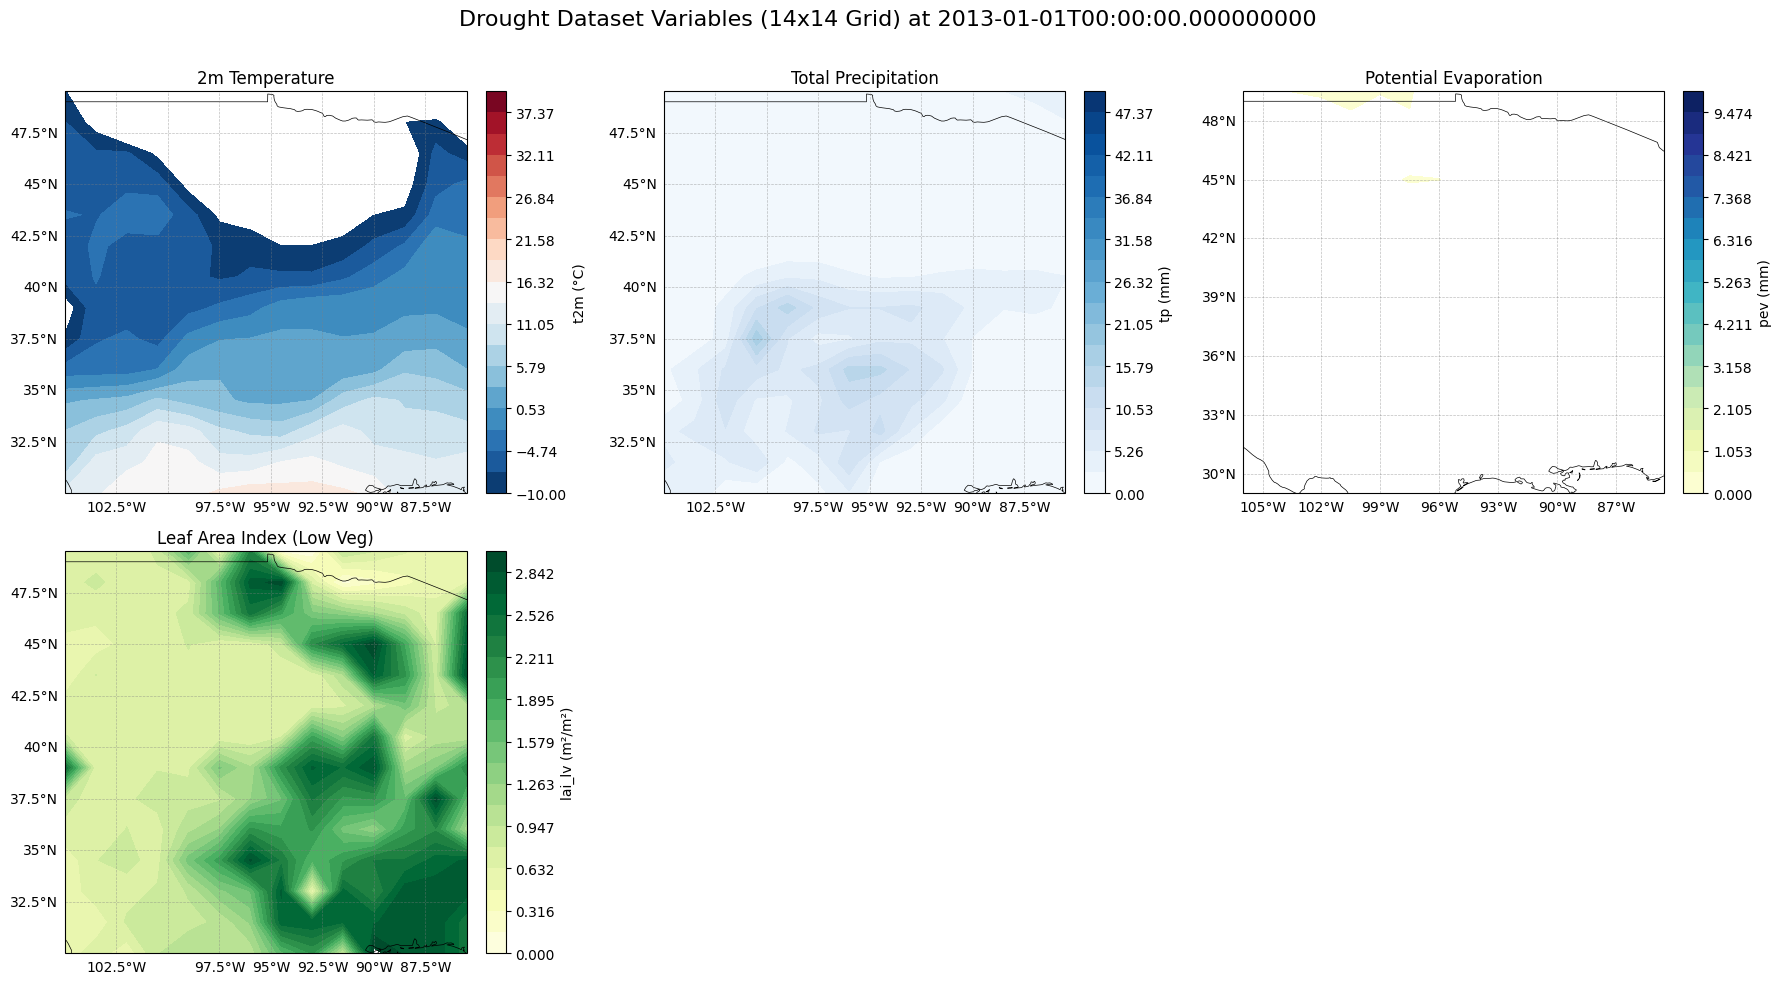

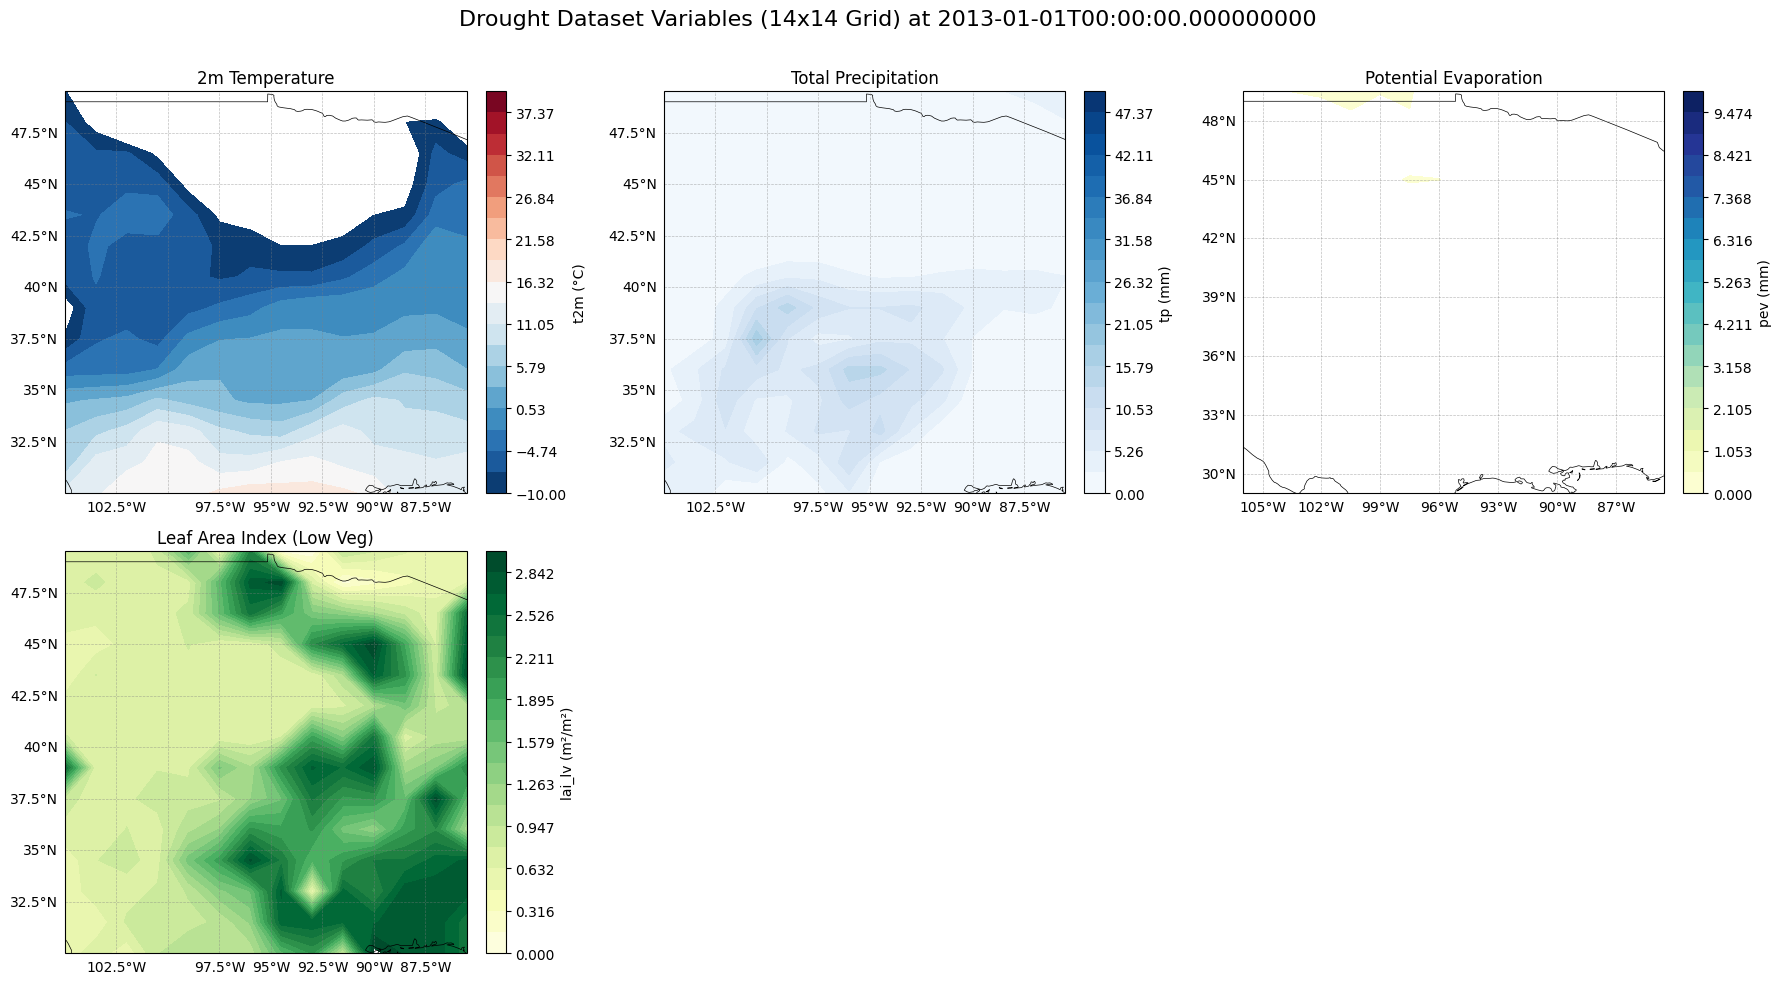

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm
import os
from matplotlib import cm

def visualize_drought_data(data_file='/content/drive/MyDrive/drought_data/interpolated_imp/chaosbench_drought_imp_variables_filled_complete.nc',
                          output_dir='./drought_visualizations',
                          time_idx=0,
                          create_individual_plots=True):
    """
    Visualize drought data variables on a 14x14 grid

    Args:
        data_file: Path to the data file
        output_dir: Directory to save visualizations
        time_idx: Time index to visualize
        create_individual_plots: Whether to create individual plots for each variable
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # List of variables to visualize
    variables = ['t2m', 'd2m', 'u10', 'v10', 'tp', 'pev', 'swvl1', 'ssrd', 'lai_hv', 'lai_lv']

    # Load data
    print(f"Loading data from {data_file}...")
    data = xr.open_dataset(data_file)

    # Print dataset information
    print("Dataset information:")
    print(data)

    # Check if variables exist in the dataset
    available_vars = [var for var in variables if var in data.variables]
    if len(available_vars) < len(variables):
        missing_vars = set(variables) - set(available_vars)
        print(f"Warning: Some variables are missing from the dataset: {missing_vars}")
        variables = available_vars

    # Get coordinates
    if 'latitude' in data.dims:
        lats = data.latitude.values
        lons = data.longitude.values
    elif 'lat' in data.dims:
        lats = data.lat.values
        lons = data.lon.values
    else:
        # Create default coordinates if not found
        print("Warning: No latitude/longitude coordinates found. Using default grid.")
        lats = np.linspace(30, 50, 14)  # Example: Europe
        lons = np.linspace(-10, 20, 14)

    # Print grid dimensions
    print(f"Grid dimensions: {len(lats)}x{len(lons)}")

    # Create mesh grid for plotting
    lon_grid, lat_grid = np.meshgrid(lons, lats)

    # Variable units and titles
    var_units = {
        't2m': 'K',
        'd2m': 'K',
        'u10': 'm/s',
        'v10': 'm/s',
        'tp': 'm',
        'pev': 'm',
        'swvl1': 'm³/m³',
        'ssrd': 'J/m²',
        'lai_hv': 'm²/m²',
        'lai_lv': 'm²/m²',
    }

    # Variable display names
    var_names = {
        't2m': '2m Temperature',
        'd2m': '2m Dewpoint',
        'u10': '10m Wind (U)',
        'v10': '10m Wind (V)',
        'tp': 'Total Precipitation',
        'pev': 'Potential Evaporation',
        'swvl1': 'Soil Water (Layer 1)',
        'ssrd': 'Solar Radiation',
        'lai_hv': 'Leaf Area Index (High Veg)',
        'lai_lv': 'Leaf Area Index (Low Veg)'
    }

    temp_conversion = {
        't2m': lambda x: x - 273.15,
        'd2m': lambda x: x - 273.15
    }

    precip_conversion = {
        'tp': lambda x: x * 1000,
        'pev': lambda x: x * 1000
    }

    display_units = var_units.copy()
    display_units.update({
        't2m': '°C',
        'd2m': '°C',
        'tp': 'mm',
        'pev': 'mm',
    })

    # Variable colormaps and ranges
    var_cmaps = {
        't2m': ('RdBu_r', (-10, 40)),
        'd2m': ('BrBG', (-10, 30)),
        'u10': ('coolwarm', (-15, 15)),
        'v10': ('coolwarm', (-15, 15)),
        'tp': ('Blues', (0, 50)),
        'pev': ('YlGnBu', (0, 10)),
        'swvl1': ('YlGnBu', (0, 0.5)),
        'ssrd': ('YlOrRd', (0, 5e7)),
        'lai_hv': ('Greens', (0, 7)),
        'lai_lv': ('YlGn', (0, 3))
    }

    # Set up figure parameters
    n_vars = len(variables)
    n_cols = min(3, n_vars)
    n_rows = (n_vars + n_cols - 1) // n_cols

    fig_width = 6 * n_cols
    fig_height = 5 * n_rows

    # Create figure
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height),
                           subplot_kw={'projection': ccrs.PlateCarree()})

    # Make axs a 2D array if it's 1D or a single Axes
    if n_vars == 1:
        axs = np.array([[axs]])
    elif n_rows == 1:
        axs = axs.reshape(1, -1)
    elif n_cols == 1:
        axs = axs.reshape(-1, 1)

    # For each variable, create a subplot
    for i, var in enumerate(variables):
        row = i // n_cols
        col = i % n_cols
        ax = axs[row, col]

        try:
            # Get data for this variable at the specified time
            if 'time' in data.dims:
                var_data = data[var].isel(time=time_idx).values
                time_str = str(data.time.values[time_idx])
                print(f"Plotting {var} at time {time_str}")
            else:
                var_data = data[var].values
                time_str = "N/A"
                print(f"Plotting {var} (no time dimension)")

            # Apply any necessary conversions for display
            if var in temp_conversion:
                var_data = temp_conversion[var](var_data)
                print(f"Converted {var} from Kelvin to Celsius")
            elif var in precip_conversion:
                var_data = precip_conversion[var](var_data)
                print(f"Converted {var} from m to mm")

            # Get colormap and range for this variable
            cmap_name, data_range = var_cmaps.get(var, ('viridis', (None, None)))
            vmin, vmax = data_range

            # If range not specified, calculate from data
            if vmin is None:
                vmin = np.nanmin(var_data)
            if vmax is None:
                vmax = np.nanmax(var_data)

            # Create colormap
            cmap = cm.get_cmap(cmap_name)

            # Create the contourf plot
            if var in ['u10', 'v10']:  # Use diverging colormap for wind components
                norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
                cf = ax.contourf(lon_grid, lat_grid, var_data,
                               levels=np.linspace(vmin, vmax, 20),
                               cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
            else:
                cf = ax.contourf(lon_grid, lat_grid, var_data,
                               levels=np.linspace(vmin, vmax, 20),
                               cmap=cmap, transform=ccrs.PlateCarree())

            # Add coastlines, borders, and gridlines
            ax.coastlines(resolution='50m', linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, linewidth=0.5)
            gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False

            # Add colorbar
            cbar = plt.colorbar(cf, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label(f'{var} ({display_units.get(var, "")})')

            # Set title
            ax.set_title(var_names.get(var, var))

        except Exception as e:
            print(f"Error plotting variable {var}: {e}")
            ax.set_title(f"{var} - Error")

    # Remove any extra subplots
    for i in range(n_vars, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        fig.delaxes(axs[row, col])

    # Add overall title
    time_info = f" at {time_str}" if 'time' in data.dims else ""
    plt.suptitle(f'Drought Dataset Variables (14x14 Grid){time_info}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])

    # Save the figure
    output_path = os.path.join(output_dir, f'drought_variables_{time_idx:04d}.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Combined visualization saved to {output_path}")

    if create_individual_plots:
        for var in variables:
            try:
                # Get data for this variable at the specified time
                if 'time' in data.dims:
                    var_data = data[var].isel(time=time_idx).values
                else:
                    var_data = data[var].values

                # Apply any necessary conversions for display
                if var in temp_conversion:
                    var_data = temp_conversion[var](var_data)
                elif var in precip_conversion:
                    var_data = precip_conversion[var](var_data)

                # Create figure
                plt.figure(figsize=(10, 8))
                ax = plt.axes(projection=ccrs.PlateCarree())

                # Get colormap and range
                cmap_name, data_range = var_cmaps.get(var, ('viridis', (None, None)))
                vmin, vmax = data_range

                # If range not specified, calculate from data
                if vmin is None:
                    vmin = np.nanmin(var_data)
                if vmax is None:
                    vmax = np.nanmax(var_data)

                cmap = cm.get_cmap(cmap_name)

                if var in ['u10', 'v10']:
                    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
                    cf = ax.contourf(lon_grid, lat_grid, var_data,
                                  levels=np.linspace(vmin, vmax, 30),
                                  cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
                else:
                    cf = ax.contourf(lon_grid, lat_grid, var_data,
                                  levels=np.linspace(vmin, vmax, 30),
                                  cmap=cmap, transform=ccrs.PlateCarree())

                # Add features
                ax.coastlines(resolution='50m', linewidth=0.8)
                ax.add_feature(cfeature.BORDERS, linewidth=0.8)
                ax.add_feature(cfeature.RIVERS, linewidth=0.5, alpha=0.5)

                # Add gridlines
                gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                gl.top_labels = False
                gl.right_labels = False

                # Add colorbar
                cbar = plt.colorbar(cf, fraction=0.046, pad=0.04)
                cbar.set_label(f'{var} ({display_units.get(var, "")})')

                # Set title
                time_info = f" at {time_str}" if 'time' in data.dims else ""
                plt.title(f"{var_names.get(var, var)}{time_info}")

                # Save the individual plot
                var_path = os.path.join(output_dir, f'{var}_{time_idx:04d}.png')
                plt.savefig(var_path, dpi=300, bbox_inches='tight')
                plt.close()

                print(f"Individual plot for {var} saved to {var_path}")

            except Exception as e:
                print(f"Error creating individual plot for {var}: {e}")

    data.close()

    return fig

# For a single time step visualization:
visualize_drought_data(
    data_file='/content/drive/MyDrive/drought_data/interpolated_imp/chaosbench_drought_imp_variables_filled_complete.nc',
    output_dir='./drought_visualizations',
    time_idx=0,
    create_individual_plots=True
)